# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [83]:
# imports
import re
import time
import json
import pydot
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from csv import reader
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from random import seed, randrange
from collections import defaultdict
import matplotlib.patches as mpatches


# Imports for DF and MLIB
from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions
import pyspark.sql.functions as func
from pyspark.sql.functions import col, countDistinct, approxCountDistinct, count, when, desc
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.functions import *

In [5]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [6]:
# start Spark Session
from pyspark.sql import SparkSession


app_name = "FinalProject"
sc.stop()
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'), ('spark.executor.cores', '4'), ('spark.cores.max', '24'), ('spark.driver.memory','10g')])
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

## 1. Question Formulation


### Background 

The following analysis is based on a Kaggle dataset from Criteo, an internet advertising company focused on retargeting. Criteo's goal is to increase online clickthrough rates among consumers who have previously visited an advertiser's website. This information will be used by Criteo to more efficiently provide the right ads to the right people. Optimizing the retargeting process not only helps advertisers become more efficient in terms of how they spend their dollars, but also it reduces clutter for consumers who do not want to be "followed" by ads for irrelevant products (or ones they may have already purchased!). **Our goal is to create a model that will most accurately predict clickthroughs (label = 1); Due to binary categorical nature of the output label (0,1), we are exploring classification models for analysis.** 

Features given in the data set most likely represent characterstics about consumer behavior (history of clickthroughs, site visitiation, etc.), the ads themselves (product, creative approach, placement, etc.) and general metrics such as the date the ad was published.  However **since there is no visibility into what each feature represents, our challenge is to make our predictions based on the data alone. With over 6 million records to train each day (~45 million per week), this will require a scalable approach**.


### Dataset Introduction 

The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates 75% - 0 Class, 25% - Class) in order to reduce the dataset size.

**There are 13 numerical features (mostly count features) and 26 categorical features in this dataset. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed**. Some features may have missing values. All the rows are chronologically ordered. The test set is computed in the same way as the training set but it corresponds to events on the day following the training period and does not have the label column. Since, there is no time data available, we are not considering this dataset to be a time series model.


### Key Questions: Features and Model

#### 1. Which features are most important in predicting clickthroughs?

Having this information can help Criteo focus on the metrics that are most critical to their product. With 39 features, there is a high risk of overfitting. We should identify a model that provides an optimal tradeoff between bias and variance. **Since we didnt get any metadata about the features, we are relying on EDA and regularization techniques to help us determine the important features and reduce dimensionality of the feature space**.


#### 2. Which machine learning approach not only provides the highest accuracy in predicting clickthroughs, but is also scalable enough to be useful in a production environment?

As internet patterns and product choices change rapidly, the ideal model should be trained daily to update the following day's retargeting model. Scaling would help us achieve shorter training times than processing records sequentially. **Any ML algorithm which can be trained using associative and commutative properties (ex. simple addition, with no state dependencies) such as Batch Logisitc Regression or Tree Algorithms based can be used for scaling the training approach.**

## 2. EDA & Discussion of Challenges

### Goals for this section:

#### PART A: Loading and Creating files with pre-processing 

1. Create RDDs for full train and test files. 
2. Sample full train RDD to create trainRDD for training, heldOutRDD for testing and a random sample of 1000 rows as toy dataset for demonstration purpose ('toy1000.txt').
3. Take another random sample of 300 rows from the train file ('toy_test300.txt') which will be used to validate ML models in later sections. 

#### PART B: EDA with Toy Dataset and RDDs/Pandas

Perform EDA on toy dataset using pandas/RDDs including visualizations that help inform our data transformation decisions.  

#### PART C:  EDA on Full Dataset with Dataframes 

Perform EDA on full train dataset using Dataframes.

#### PART D: Data Transformation on Toy Dataset
Data transformations using Spark RDDs on toy dataset.  

**NOTE: In section 4, we perform the same data transformations on entire dataset using Spark Dataframes for Spark ML models.**

### PART A: LOADING AND CREATING FILES WITH PRE-PROCESSING

### Files and Columns Details:

1. **Full Train File 'train.txt'**:  Number of rows: 45840617 (~ 45 million; ~ 10 GB) 40 columns
2. **Full Test File 'test.txt'**: Number of rows: 6042135 (~ 6 million; 1.4 GB) 39 columns (all columns except label column)
3. **Toy Train File 'toy100.txt'**: A random sample of 1000 rows as toy dataset for demonstration purpose with the same number of columns as the train file. 
4. **Toy Test File 'toy_test300.txt'**: A random sample of 300 rows as toy test dataset with the same of columns as the train file and validation of ML models in later section. 
4. **Columns**: 40
    -  13 Numerical Features I1-I13
    -  26 Categorical Features C1-C26
    -  1 Label Column - 0 or 1   

### 2.1 Data Loading

In [7]:
# load the full train and test files

fullTrainRDD = sc.textFile('gs://arvindw261bucket/train.txt')
testRDD = sc.textFile('gs://arvindw261bucket/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

# Get categorical and numeric field names separately
NUM_FIELDS = FIELDS[0:13]
CAT_FIELDS = list(set(FIELDS)-set(NUM_FIELDS))

In [8]:
# number of rows in full train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


### 2.2 Creating Train and Test Split

In [9]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9172586 records for evaluation and assigned 36668031 for training.


### 2.3 Creating a toy RDD

#### 2.3.1 Toy Train Set 

A train toy data set was created by randomly sampling 1000 records from the dataset: 

`!gshuf -n 1000 data/train.txt >> data/toy1000.txt`

In [10]:
toyRDD = sc.textFile('gs://arvindw261bucket/toy1000.txt')
print(f"Number of records in toy data: {toyRDD.count()} ...")

Number of records in toy data: 1000 ...


In [11]:
print(toyRDD.take(1))

['1\t0\t478\t13\t\t3396\t194\t11\t13\t312\t0\t7\t\t\t05db9164\t207b2d81\t1757640a\t06148e59\t25c83c98\tfbad5c96\tf36791d8\t0b153874\ta73ee510\tc7009b63\t2714650d\t1a69f1c0\t9a88e2e2\t07d13a8f\t0c67c4ca\t8075af0c\te5ba7672\t395856b0\t21ddcdc9\tb1252a9d\t8e4884c0\t\t423fab69\tb936bfbe\t001f3601\tf2fc1d6e']


#### 2.3.1 Toy Test Set 

We will randomly sample a toy held-out dataset frim the `train.txt` file.

`!gshuf -n 300 data/train.txt >> data/toy_test300.txt`

In [12]:
toy_testRDD = sc.textFile('gs://arvindw261bucket/toy_test300.txt')

### 2.4 Pre-Processing

In [13]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append('null')
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [14]:
# Parsing, making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()
toyRDDCached = toyRDD.map(parse).map(edit_data_types).cache()

In [15]:
print(trainRDDCached.take(1))

[([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, 'null', 2.0, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', 'null', '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], 0)]


In [16]:
print(toyRDDCached.take(1))

[([0.0, 478.0, 13.0, 'null', 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 'null', 'null', '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.4.1 Some extra pre-processing for a pandas DataFrame for EDA use

In [17]:
# helper function 'null' to np.nan for pandas df 
def null_to_nan(line):
    """
    converts "null" to np.nan in RDD
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == 'null':
            formated_features.append(np.nan)
        else:
            formated_features.append(value)
    return (formated_features, label)

# put the toy RDD into a pandas dataframe for EDA charting
toyRDDtoPandas = toyRDDCached.map(null_to_nan) \
                                .map(lambda x: np.append(x[0], [x[1]])) \
                                .collect()

toy_df = pd.DataFrame(toyRDDtoPandas, columns=FIELDS)

In [18]:
toy_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.0,478.0,13.0,nan,3396.0,194.0,11.0,13.0,312.0,0.0,...,395856b0,21ddcdc9,b1252a9d,8e4884c0,nan,423fab69,b936bfbe,001f3601,f2fc1d6e,1
1,2.0,0.0,nan,nan,1209.0,0.0,2.0,1.0,0.0,1.0,...,526e8765,nan,nan,8b7fb864,nan,32c7478e,45b2acf4,nan,nan,0
2,nan,1.0,1.0,8.0,489.0,66.0,0.0,11.0,8.0,nan,...,8f9b4e88,nan,nan,050a23dc,nan,32c7478e,8a3cfad4,nan,nan,0
3,0.0,179.0,7.0,8.0,996.0,67.0,6.0,44.0,344.0,0.0,...,2804effd,nan,nan,723b4dfd,nan,32c7478e,b34f3128,nan,nan,0
4,2.0,2.0,10.0,27.0,1101.0,29.0,11.0,42.0,241.0,1.0,...,e88ffc9d,21ddcdc9,b1252a9d,dca9a28d,ad3062eb,bcdee96c,3fdb382b,cb079c2d,1c2df582,1


### PART B: EDA WITH TOY DATASET USING RDDs/PANDAS

### 2.5 Labels

First we take a look at the percentage of records that belong to each label for our classification problem in order to determine whether our classes are balanced. 

In [19]:
# TOY DATA
# counting records for each class 
count_label_0 = toyRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = toyRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

72.3 % of the records have label=0 and 27.7 % have label=1...


In [20]:
# FULL DATA  ( Don't re-run this!!! )
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


The result above show that the **labels are imbalanced**, with 75% of records having label=0 (i.e. unclicked ads). However, we will not attempt to balance the labels at this stage. **Being aware of this imbalance, we will carefully examine the prediction results to detect any model bias (i.e. predicting always label=0)**

### 2.6 Counting nulls in each column

Then, we take a look at the percentage of null values for all columns in our dataset. 

In [21]:
def get_pct_nulls_in_column(dataRDD, var_position):
    """
    Counts the % nulls in a column 
    """

    null_count = dataRDD.map(lambda x: x[0][var_position]) \
                             .filter(lambda x: x == 'null').count()
    total_count = dataRDD.map(lambda x: x[0][var_position]).count()

    return null_count/total_count*100

In [22]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position < 39:
        null_pct = get_pct_nulls_in_column(toyRDDCached, var_position)
        print("FEATURE {}: {}% is null".format(var, np.round(null_pct,2)))

FEATURE I1: 43.2% is null
FEATURE I2: 0.0% is null
FEATURE I3: 21.3% is null
FEATURE I4: 22.1% is null
FEATURE I5: 2.4% is null
FEATURE I6: 23.0% is null
FEATURE I7: 3.7% is null
FEATURE I8: 0.0% is null
FEATURE I9: 3.7% is null
FEATURE I10: 43.2% is null
FEATURE I11: 3.7% is null
FEATURE I12: 77.4% is null
FEATURE I13: 22.1% is null
FEATURE C1: 0.0% is null
FEATURE C2: 0.0% is null
FEATURE C3: 3.4% is null
FEATURE C4: 3.4% is null
FEATURE C5: 0.0% is null
FEATURE C6: 13.4% is null
FEATURE C7: 0.0% is null
FEATURE C8: 0.0% is null
FEATURE C9: 0.0% is null
FEATURE C10: 0.0% is null
FEATURE C11: 0.0% is null
FEATURE C12: 3.4% is null
FEATURE C13: 0.0% is null
FEATURE C14: 0.0% is null
FEATURE C15: 0.0% is null
FEATURE C16: 3.4% is null
FEATURE C17: 0.0% is null
FEATURE C18: 0.0% is null
FEATURE C19: 42.2% is null
FEATURE C20: 42.2% is null
FEATURE C21: 3.4% is null
FEATURE C22: 74.5% is null
FEATURE C23: 0.0% is null
FEATURE C24: 3.4% is null
FEATURE C25: 42.2% is null
FEATURE C26: 42.2%

We notice that some columns have a high % of null values. **We could exclude columns that have more than 50% nulls when calculated on full train dataset because those columns will likely not contribute a lot to the prediction results. However, since those variables with more than 50% missing values are categorical variables, the one-hot encoding approach that we will take later on will take care of this issue**.

### 2.7 Numeric Features

#### 2.7.1 Get Summary Statistics and Distributions

Next, we take a look at the summary statistics for our numerical features in order to determine their distributions and detect outliers. 

In [23]:
# RDD version 
def get_stats(dataRDD, var_position):
    """
    Get statistics for numeric variables 
    stats: mean, median, variance, min, max 
    """

    mean = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').mean() 
    variance = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').variance() 
    minimum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').min() 
    maximum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').max() 

    return mean, variance, minimum, maximum

In [24]:
# save the means in a dictionary
mean_dict_toy = {}
st_dev_dict_toy = {}

# get summary stats with RDDs
for var_position, var in enumerate(FIELDS):
    if var_position < 13:
        mean, variance, minimum, maximum = get_stats(toyRDDCached, var_position)
        print("FEATURE {}: \t mean={}, \t variance={}, \t min={}, \t max={}".format(var, np.round(mean, 2), np.round(variance, 2), minimum, maximum))
        mean_dict_toy[var_position] = mean
        st_dev_dict_toy[var_position] = np.sqrt(variance)

FEATURE I1: 	 mean=3.17, 	 variance=33.98, 	 min=0.0, 	 max=55.0
FEATURE I2: 	 mean=114.72, 	 variance=179230.84, 	 min=-2.0, 	 max=5123.0
FEATURE I3: 	 mean=18.78, 	 variance=2026.69, 	 min=0.0, 	 max=648.0
FEATURE I4: 	 mean=7.43, 	 variance=86.02, 	 min=0.0, 	 max=77.0
FEATURE I5: 	 mean=18392.77, 	 variance=4908735552.87, 	 min=0.0, 	 max=1002457.0
FEATURE I6: 	 mean=95.23, 	 variance=65007.31, 	 min=0.0, 	 max=4304.0
FEATURE I7: 	 mean=17.94, 	 variance=8794.35, 	 min=0.0, 	 max=2614.0
FEATURE I8: 	 mean=12.96, 	 variance=183.6, 	 min=0.0, 	 max=49.0
FEATURE I9: 	 mean=102.42, 	 variance=38152.34, 	 min=0.0, 	 max=2711.0
FEATURE I10: 	 mean=0.64, 	 variance=0.5, 	 min=0.0, 	 max=4.0
FEATURE I11: 	 mean=2.78, 	 variance=23.83, 	 min=0.0, 	 max=60.0
FEATURE I12: 	 mean=1.19, 	 variance=40.19, 	 min=0.0, 	 max=84.0
FEATURE I13: 	 mean=7.99, 	 variance=116.35, 	 min=0.0, 	 max=97.0


In [25]:
# Pandas version 
num_columns = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']
toy_df_num = toy_df[num_columns].astype(np.float)
toy_df_num.describe()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,568.000000,1000.000000,787.000000,779.000000,9.760000e+02,770.000000,963.000000,1000.000000,963.000000,568.000000,963.000000,226.000000,779.000000
mean,3.167254,114.719000,18.780178,7.427471,1.839277e+04,95.231169,17.942887,12.961000,102.419522,0.642606,2.778816,1.194690,7.993582
std,5.834144,423.568469,45.047402,9.280591,7.009829e+04,255.131025,93.826907,13.556669,195.427732,0.705795,4.884305,6.353803,10.793634
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,3.032500e+02,6.000000,1.000000,2.000000,10.500000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,2.000000,6.000000,4.000000,2.696000e+03,28.000000,3.000000,8.000000,39.000000,1.000000,1.000000,0.000000,4.000000
75%,4.000000,32.000000,18.000000,10.000000,9.703500e+03,92.750000,12.000000,20.000000,101.000000,1.000000,3.000000,0.000000,10.000000
max,55.000000,5123.000000,648.000000,77.000000,1.002457e+06,4304.000000,2614.000000,49.000000,2711.000000,4.000000,60.000000,84.000000,97.000000


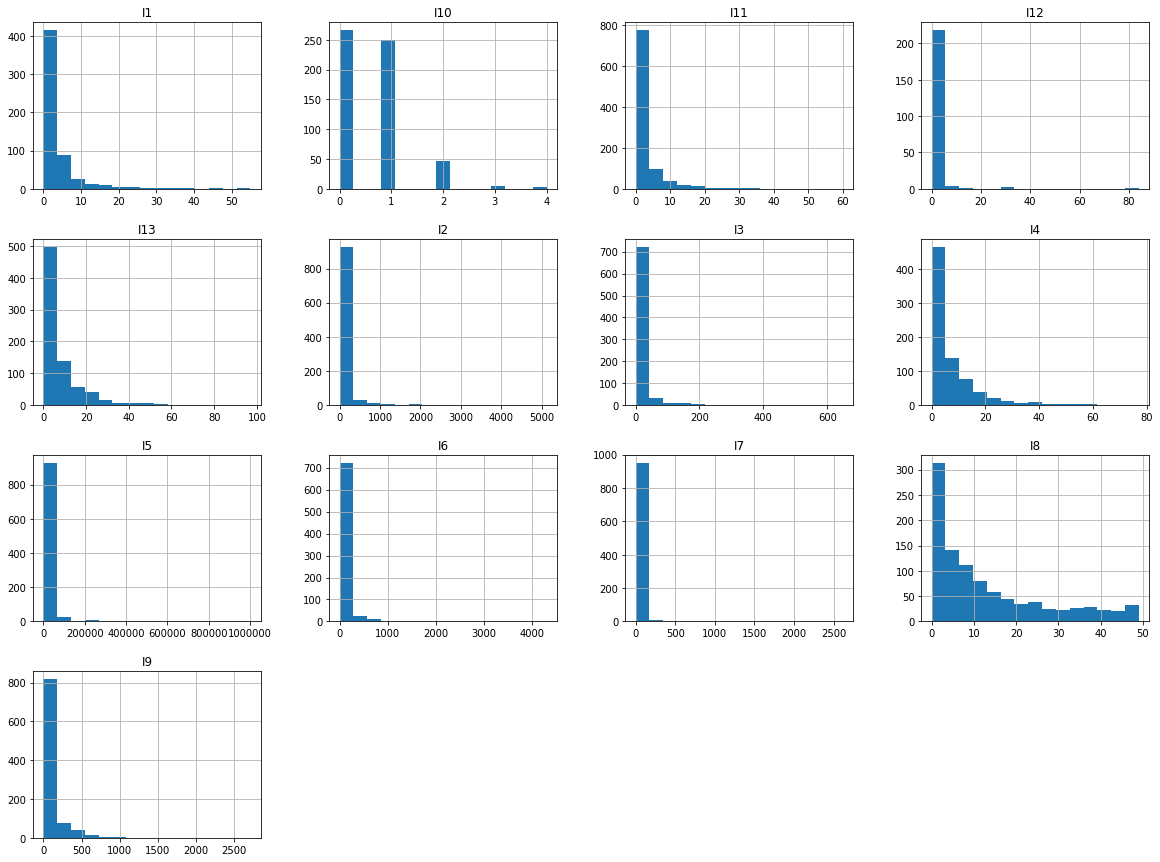

In [26]:
# Take a look at histograms for each numeric feature 
toy_df_num.hist(figsize=(20,15), bins=15)
plt.show()

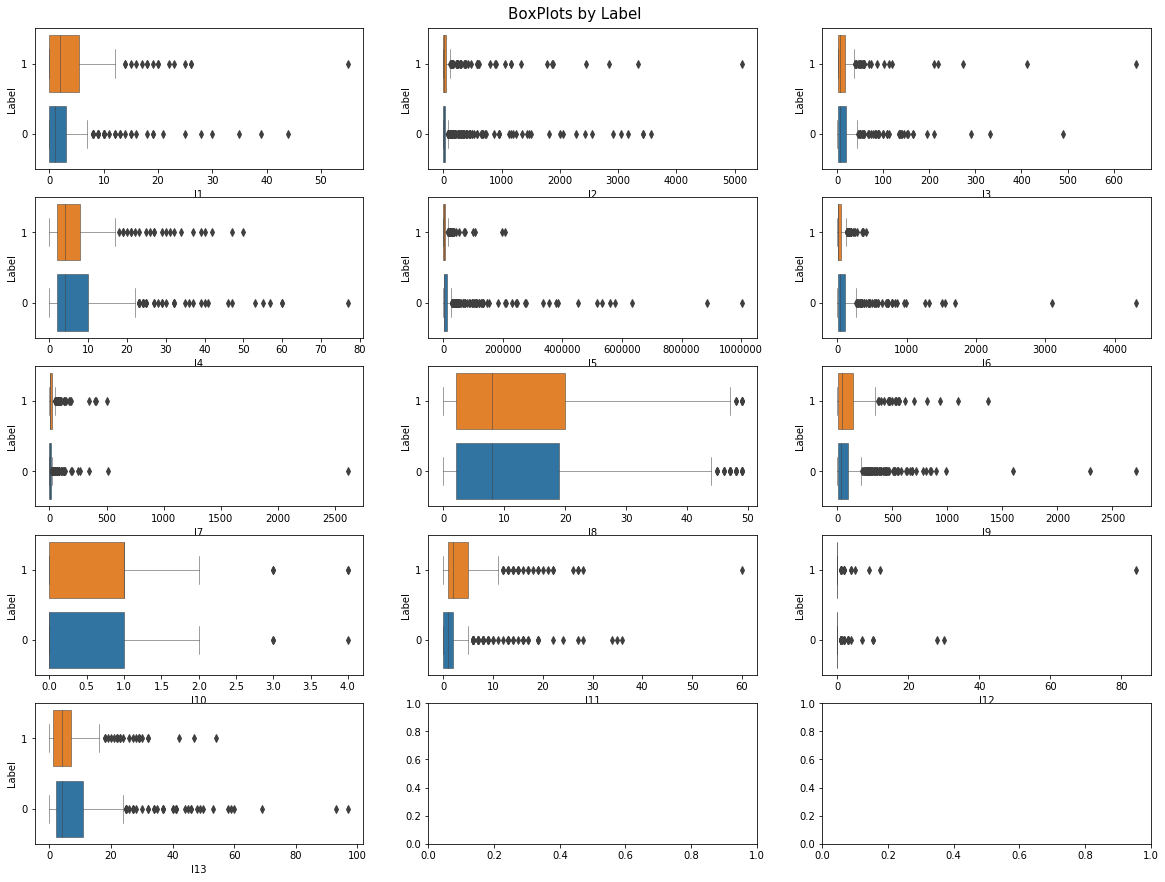

In [27]:
# plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(5, 3, figsize=(20,15))
y = toy_df['Label']
for idx, feature in enumerate(num_columns):
    x = toy_df_num[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

**The above results show that most of the numeric features are heavily skewed with several outliers on the right end. Hence, we decided to impute the missing values in the numeric features with median value for each corresponding column than mean as mean will be skewed due to the large number of outliers.** 

#### 2.7.2 Correlations

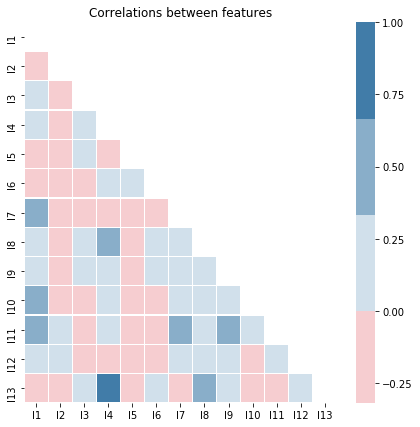

In [28]:
# Correlation between numerical features
corr = toy_df_num.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

**We observe that some of the numerical variables are highly correlated with each other. In the context of Logistic Regression we would want to eliminate features that are highly correlated with each other. A regularization  technique like Lasso or Ridge could take care of this. However, since Logistic regression is just our baseline model and we are focusing on tree-based algorithms, we do not need to worry about this. Tree-based models know how to assign variable importance and do not require any significant feature engineering.** 

### 2.8 Categorical Features

In this section, we will perform data processing on the 26 categorical features of the dataset. We will start by performing some EDA to compute the **number of unique categories** within each categorical feature and the total counts for each category. 

In [29]:
def count_categories(dataRDD, var, var_position, top):
    """
    input: RDD, name and position of a categorical variable 
    
    output: 
    * number of unique categories in the variable
    * counts of each category occurance by label
    """
    
    # counting category occurance within each categorical feature 
    count_per_category = dataRDD.map(lambda x: ( x[0][var_position], 1)) \
                                           .reduceByKey(lambda x,y: x+y) \
                                           .sortBy(lambda x: -x[1])

    # counting number of unique values within the categorical variable
    num_unique_values = count_per_category.map(lambda x: x[0]).distinct().count()

    print('Unique values within the category:', num_unique_values)
    print(' ')
    top_x = count_per_category.take(top)
    print('Top {} categories by count:'.format(top))
    for i in top_x: 
        print('Category: {}; Count: {}'.format(i[0],i[1]))
    print(' ')

In [30]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position > 12 and var_position < 39:
        print(" ")
        print("VARIABLE {}".format(var))
        print(" ")
        count_categories(toyRDDCached, var, var_position=var_position, top=10)

 
VARIABLE C1
 
Unique values within the category: 57
 
Top 10 categories by count:
Category: 05db9164; Count: 485
Category: 68fd1e64; Count: 146
Category: 5a9ed9b0; Count: 103
Category: 8cf07265; Count: 51
Category: be589b51; Count: 41
Category: 5bfa8ab5; Count: 27
Category: f473b8dc; Count: 20
Category: 87552397; Count: 15
Category: 39af2607; Count: 13
Category: 9a89b36c; Count: 9
 
 
VARIABLE C2
 
Unique values within the category: 193
 
Top 10 categories by count:
Category: 38a947a1; Count: 114
Category: 1cfdf714; Count: 50
Category: 287130e0; Count: 46
Category: 38d50e09; Count: 46
Category: 207b2d81; Count: 37
Category: 09e68b86; Count: 33
Category: 421b43cd; Count: 33
Category: 4f25e98b; Count: 29
Category: 89ddfee8; Count: 27
Category: 58e67aaf; Count: 27
 
 
VARIABLE C3
 
Unique values within the category: 771
 
Top 10 categories by count:
Category: null; Count: 34
Category: d032c263; Count: 15
Category: 02cf9876; Count: 13
Category: b00d1501; Count: 12
Category: 77f2f2e5; Cou

Unique values within the category: 489
 
Top 10 categories by count:
Category: 3fdb382b; Count: 56
Category: b34f3128; Count: 50
Category: 1793a828; Count: 49
Category: null; Count: 34
Category: 3b183c5c; Count: 31
Category: aee52b6f; Count: 25
Category: 45ab94c8; Count: 22
Category: 9117a34a; Count: 19
Category: df487a73; Count: 16
Category: 8fc66e78; Count: 15
 
 
VARIABLE C25
 
Unique values within the category: 30
 
Top 10 categories by count:
Category: null; Count: 422
Category: 001f3601; Count: 135
Category: e8b83407; Count: 112
Category: ea9a246c; Count: 84
Category: cb079c2d; Count: 44
Category: f0f449dd; Count: 35
Category: 445bbe3b; Count: 30
Category: 010f6491; Count: 29
Category: 2bf691b1; Count: 28
Category: 9b3e8820; Count: 28
 
 
VARIABLE C26
 
Unique values within the category: 375
 
Top 10 categories by count:
Category: null; Count: 422
Category: 49d68486; Count: 38
Category: 2fede552; Count: 22
Category: c27f155b; Count: 19
Category: c84c4aec; Count: 15
Category: 984e

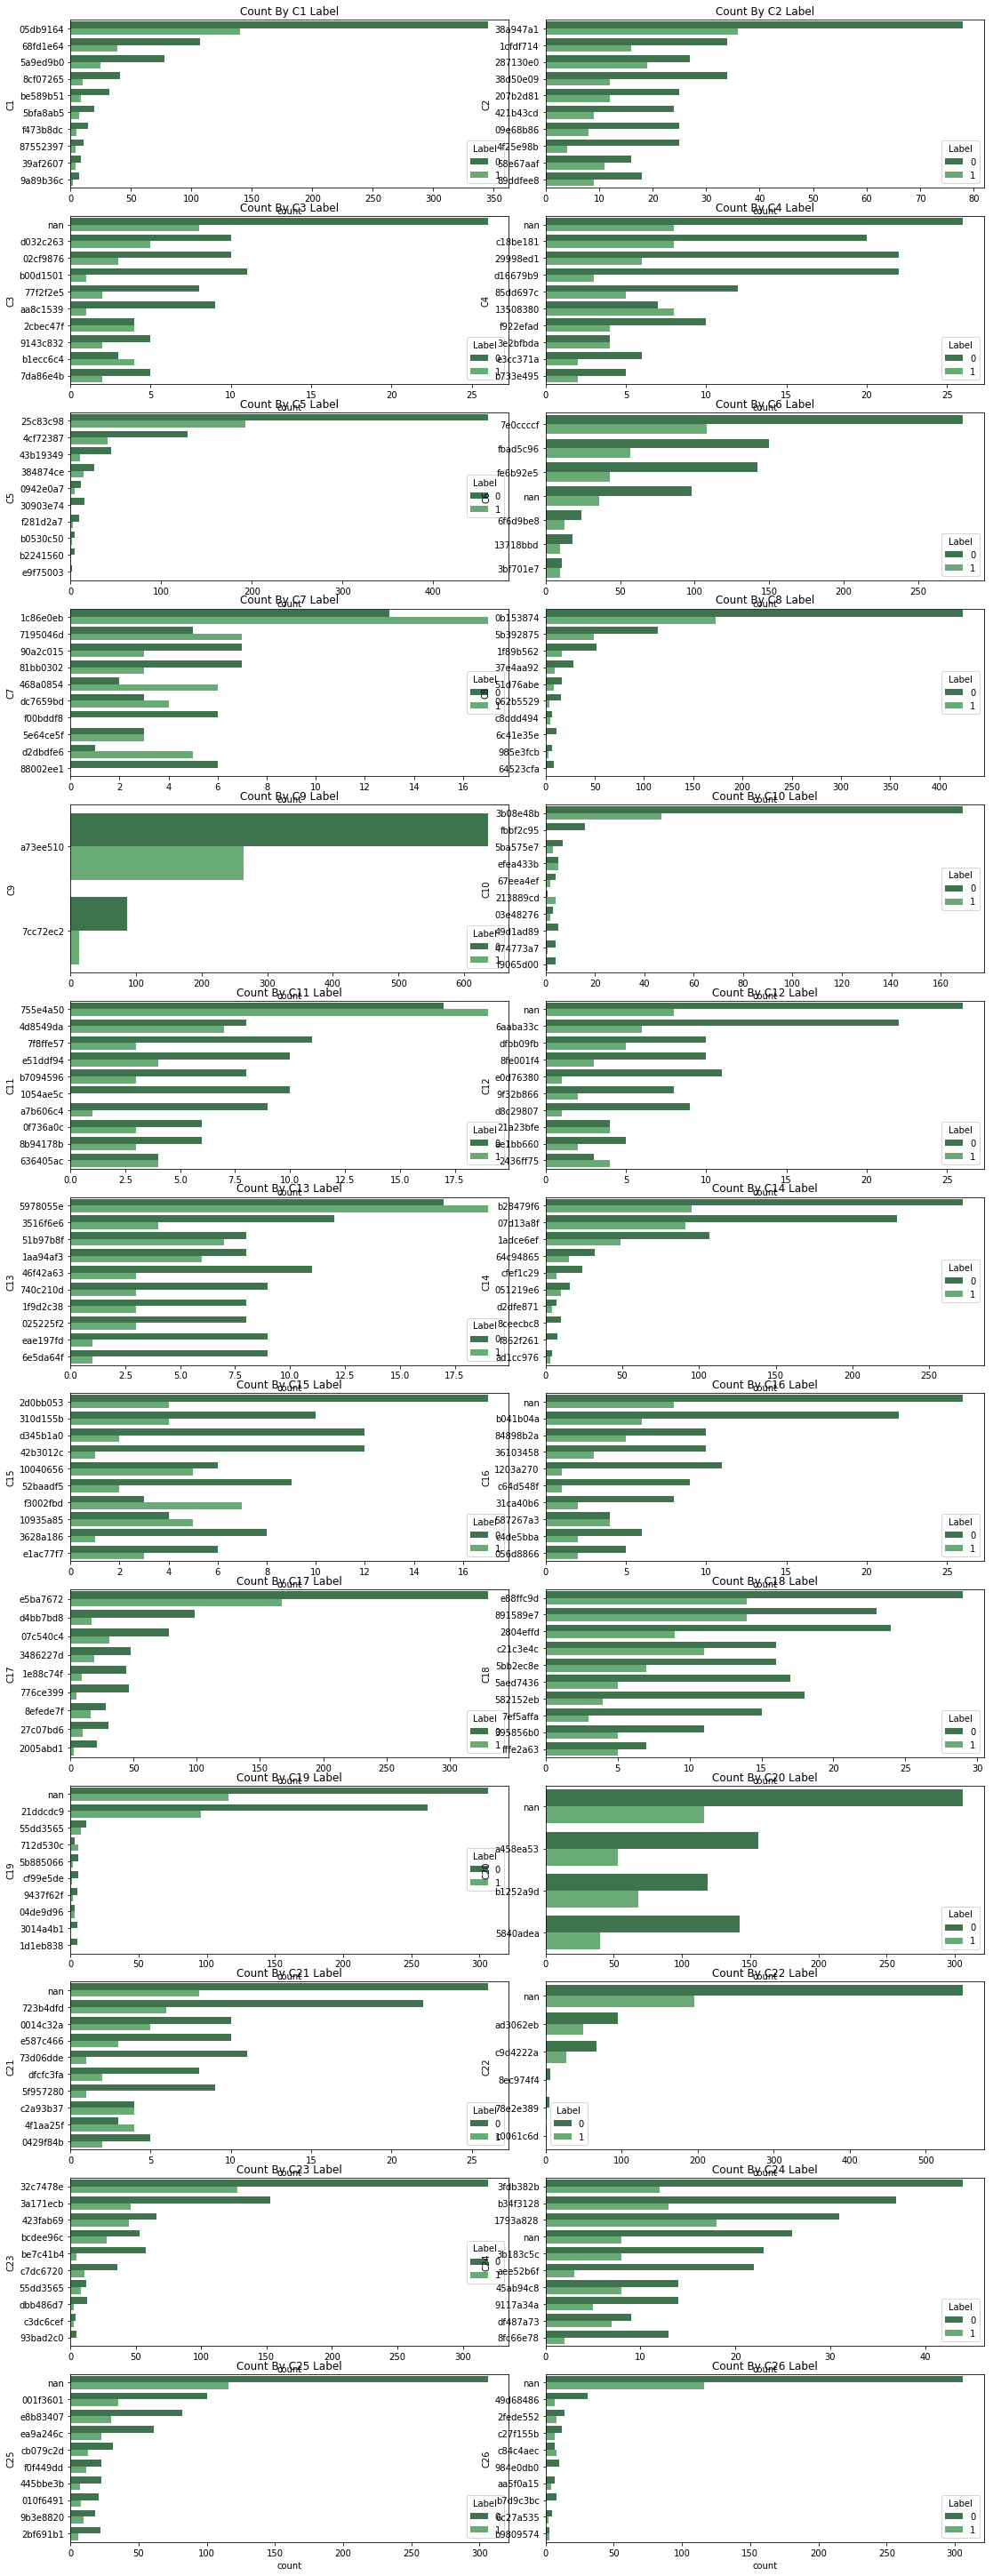

In [31]:
# Bar graphs of category counts within each categorical variable by label
fig, ax = plt.subplots(13, 2,figsize=(15,40))
plt.tight_layout()
fno = 0
# axes are in a two-dimensional array, indexed by [row, col]
for i in range(13):
    for j in range(2):
        fno += 1
        col = "C" + str(fno)
        sns.countplot(y=col, hue="Label", data=toy_df, palette="Greens_d",
                  order=toy_df[col].value_counts().iloc[:10].index,ax=ax[i,j]).set_title('Count By C'+str(fno)+' Label')

**The above analysis shows that some categorical variables have a high number of unique categories. Aditionally, the distribution of counts for most of the categorical variables is very skewed (i.e. some categories appear much more often than others). Considering this information, we decided to bucket the categorical features into 'High', 'Medium', 'Rare' and 'Missing' buckets for each column which will be explained later in the data transformation section.** 

### PART C:  EDA ON FULL DATASET USING DATAFRAMES

### 2.9 Creating a dataframe for TrainRDD (from above)

In [34]:
sampleDF = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).map(lambda x: x.tolist()).toDF(FIELDS).cache()
                                                                   
# Converting Columns to Numeric Type
for col_name in NUM_FIELDS:
    sampleDF = sampleDF.withColumn(col_name, col(col_name).cast('float'))

sampleDF = sampleDF.withColumn("Label", col("Label").cast('int')).cache()

# Show col types and top row
start = time.time()
sampleDF.head(1)
print(f'\n... {time.time() - start} seconds.')


... 34.41727542877197 seconds.


### 2.10 Categorical Features: 

* Get missing fields, distinct features count and high/medium frequency features for categorical columns. 


* **Each categorical column has a large number of distinct features and missing values (ex. 'C22') which makes categorical columns One Hot Encoding cumbersome** and increases the dimensionality of the feature space by several times. This will make the ML models perform not very well if these categorical columns are used as is. Hence, **as a bucketing technique we are getting the list of features by their counts to group them as 'High', 'Medium', 'Rare' or 'Missing'**. 

    * **High Frequency Features:** are those which which occur at least 10% of the time. Ex: if n = 45 million; 10% of n = 4.5million. ie. give me a list of categorical features (categories) in a column that occur at least 10% of the time. 

    * **Medium Frequency Features:** Categories that occur 2%-10% of the time in a column

    * **Rare Features**: After getting the 'High' and 'Medium' frequency features from a column, remaining features would all be clubbed under the 'Rare' category which occur less than 2% of the time 
    
    * **Missing**: If they are nulls, they are bucketed as 'Missing'.

In [44]:
start = time.time()

# Keep a dictionary of high and low features
high_features = dict()
medium_features =  dict()

# total row count
row_count = sampleDF.count()

for field in CAT_FIELDS:
    print("\nFOR COLUMN "+field+":")
    
    columnDF = sampleDF[[field]].cache()
    
    #Count of missing 
    missing_count = columnDF.select(count(when(col(field) == "null", 1))).head()[0]
    print("No. of Missing Values:", missing_count)
    
    print("Percentage of Missing values:", np.round(missing_count*100/row_count, 2), "%")
    
    # Distinct
    distinct = columnDF.agg(approxCountDistinct(col(field)).alias(field)).head()[0]
    if missing_count != 0:
        distinct = distinct -1
    print("No. of Distinct Features (without null):", distinct)
    
    # Frequent Items 
    freq10 = columnDF.stat.freqItems([field], 0.1).head()[0]
    freq2 = columnDF.stat.freqItems([field], 0.02).head()[0]
    freq2 = list(set(freq2) - set(freq10))
    print("10% Occuring Features:", freq10)
    print("2% Occuring Features:", freq2)
    
    high_features[field] = freq10
    medium_features[field] =  freq2

print(f'\n... {time.time() - start} seconds.')   


FOR COLUMN C1:
No. of Missing Values: 0
Percentage of Missing values: 0.0 %
No. of Distinct Features (without null): 1513
10% Occuring Features: ['be589b51', '87552397', '8cf07265', '05db9164', 'f473b8dc', '68fd1e64', '5a9ed9b0', '5bfa8ab5', '39af2607']
2% Occuring Features: ['561bf9d4', '291b7ba2', '24eda356', '28e55712', '41edac3d', '489d0f96', 'da4eff0f', 'd4b08d58', '09ca0b81', 'dd14f377', '169f6798', '287e684f', '7e5c2ff4', '65aada8c', '75ac2fe6', 'b8508252', '66651cdf', '9a89b36c', 'c71ae391', '9e9d28f5', '18988050', '6062d843', '2d4ea12b', '6ca3af46', 'fb174e6b', '3c9d8785', '7382c353', '439a44a4', '241546e0', '98237733', '0e78bd46', '46300ee3', 'b455c6d7', 'fbc55dae', '64e77ae7', '17f69355', '1464facd', 'f5c9f18c', '4265881a', 'e8ef605b', 'ae82ea21']

FOR COLUMN C4:
No. of Missing Values: 1248181
Percentage of Missing values: 3.4 %
No. of Distinct Features (without null): 1835689
10% Occuring Features: ['f922efad', '36722301', 'd16679b9', '8bea9951']
2% Occuring Features: ['ac

No. of Missing Values: 16136444
Percentage of Missing values: 44.01 %
No. of Distinct Features (without null): 3
10% Occuring Features: ['a458ea53', '5840adea', 'b1252a9d', 'null']
2% Occuring Features: []

FOR COLUMN C7:
No. of Missing Values: 0
Percentage of Missing values: 0.0 %
No. of Distinct Features (without null): 12494
10% Occuring Features: ['0b73ac09', '5e7fd737', 'f1ff45d6', '6cdb3998']
2% Occuring Features: ['dc7659bd', 'd2d741ca', '3965ff35', '7195046d', '45e063a0', '90a2c015', '40c1e0b6', '1c86e0eb', '468a0854']

FOR COLUMN C10:
No. of Missing Values: 0
Percentage of Missing values: 0.0 %
No. of Distinct Features (without null): 91600
10% Occuring Features: ['3b08e48b', 'befd4fae', '01a07fd7', 'e6003298', '687c8b31', '67eea4ef']
2% Occuring Features: ['d4f05169', '9598fde8', '3a7915a0', '2ed68727', 'b488961f', 'b5f7cd48', 'efea433b', '24c14a4a', 'daea64eb', 'd6133462', '0e9ead52', '726f00fd', '0c8dc039', 'fbbf2c95', '31990058', '98bd7a24', '408fa381', '99009ad9', '3757d3

### 2.11 Numerical Features

#### 2.11.1 Summary Stats

In [46]:
# Get numeric features summary stats
start = time.time()

numeric_DF = sampleDF[[NUM_FIELDS]].cache()
numeric_summaryDF= numeric_DF.describe()

# Round numeric summary stats
for field in NUM_FIELDS:
   numeric_summaryDF = numeric_summaryDF.withColumn(field, func.round(numeric_summaryDF[field], 2))

# Display numeric summary stats
numeric_summaryDF[['summary']+NUM_FIELDS[0:7]].show()
numeric_summaryDF[[NUM_FIELDS[7:]]].show()

print(f'\n... {time.time() - start} seconds.') 

+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|summary|        I1|         I2|         I3|         I4|         I5|         I6|         I7|
+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|  count|2.003638E7|3.6668031E7|2.8798323E7|2.8720329E7|3.5721211E7|2.8468498E7|3.5082452E7|
|   mean|       3.5|     105.88|      26.88|       7.32|   18541.85|     116.08|      16.34|
| stddev|       9.4|     391.96|     396.17|       8.79|   69327.05|     380.42|      66.39|
|    min|       0.0|       -3.0|        0.0|        0.0|        0.0|        0.0|        0.0|
|    max|    5775.0|   257675.0|    65535.0|      969.0|  2693697.0|   430898.0|    56311.0|
+-------+----------+-----------+-----------+-----------+-----------+-----------+-----------+

+-----------+-----------+----------+-----------+---------+-----------+
|         I8|         I9|       I10|        I11|      I12|        I13|
+-----------+-------

I12 is one of the columns that has the most missing values (> 50%). Missing values are being imputed with medians as discussed in the next sections. 

#### 2.11.2 Column Quantiles to bucket numeric features

Note: values are [min, 25%, median, 75%, max]

In [47]:
splits = []
start = time.time()

# Round numeric summary stats
for field in NUM_FIELDS:
    split = set(statFunc(sampleDF).approxQuantile(field, probabilities = [0.0,0.25,0.50,0.75,1.0], relativeError=0.2))
    splits.append(sorted(list(split)))

print("COLUMN QUANTILES (keeping only unique values for binning):\n")
print(splits)

print(f'\n... {time.time() - start} seconds.') 

COLUMN QUANTILES (keeping only unique values for binning):

[[0.0, 2.0, 546.0, 5775.0], [-3.0, 8.0, 9.0, 12358.0, 257675.0], [0.0, 9.0, 37675.0, 65535.0], [0.0, 5.0, 6.0, 417.0, 969.0], [0.0, 5067.0, 5588.0, 2403398.0, 2693697.0], [0.0, 49.0, 56.0, 134316.0, 430898.0], [0.0, 6.0, 7213.0, 56311.0], [0.0, 11.0, 1839.0, 6047.0], [0.0, 59.0, 8824.0, 25618.0], [0.0, 1.0, 7.0, 10.0], [0.0, 2.0, 137.0, 231.0], [0.0, 265.0, 269.0, 303.0, 4008.0], [0.0, 6.0, 1314.0, 7393.0]]

... 15.47182583808899 seconds.


#### 2.11.3 Bucket each numerical column based on quantiles

In [48]:
count_buckets = []
buckets = []
start = time.time()

for i,field in enumerate(NUM_FIELDS):
    if len(splits[i])==2:
        splits[i] = [-float("inf")] + splits[i] + [float("inf")]
        
    # Bucketize the values
    bucketizer = Bucketizer(handleInvalid = 'skip', splits = splits[i], inputCol=field, outputCol="bucket")
    result = bucketizer.transform(sampleDF[[field]]).cache()
    print("\nFOR COLUMN "+field+":", "splits are:", splits[i])
    
    # Get count of each bucket in a column
    bucket = result.groupBy(["bucket"]).agg(count("bucket").alias("count")).orderBy("bucket")
    count_buckets.append([value[1] for value in bucket.collect()])
    buckets.append([value[0] for value in bucket.collect()])
    print(bucket.show())
    
print("Buckets:", buckets)
print("Bucket Counts:", count_buckets)

print(f'\n... {time.time() - start} seconds.') 


FOR COLUMN I1: splits are: [0.0, 2.0, 546.0, 5775.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|12024185|
|   1.0| 8012056|
|   2.0|     139|
+------+--------+

None

FOR COLUMN I2: splits are: [-3.0, 8.0, 9.0, 12358.0, 257675.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|21565390|
|   1.0|  435333|
|   2.0|14667083|
|   3.0|     225|
+------+--------+

None

FOR COLUMN I3: splits are: [0.0, 9.0, 37675.0, 65535.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|16768941|
|   1.0|12029013|
|   2.0|     369|
+------+--------+

None

FOR COLUMN I4: splits are: [0.0, 5.0, 6.0, 417.0, 969.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|15061398|
|   1.0| 1775038|
|   2.0|11883791|
|   3.0|     102|
+------+--------+

None

FOR COLUMN I5: splits are: [0.0, 5067.0, 5588.0, 2403398.0, 2693697.0]
+------+--------+
|bucket|   count|
+------+--------+
|   0.0|21927617|
|   1.0|  542317|
|   2.0|13251216|
|   3.0|      61|
+----

#### 2.11.4 Visualize each of the bucketed numerical column 

Note: if values are too low, they are not shown in the plot. Look at count values in title to determine which buckets are a minority/outliers.

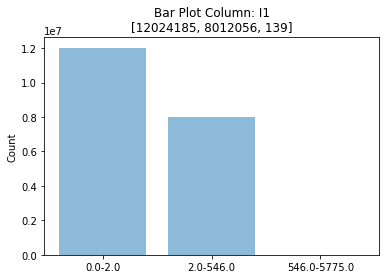

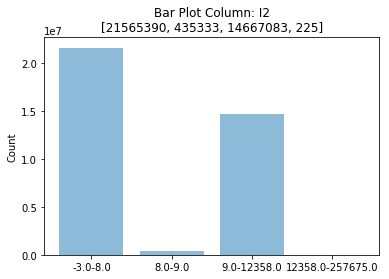

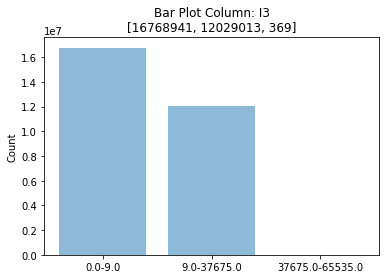

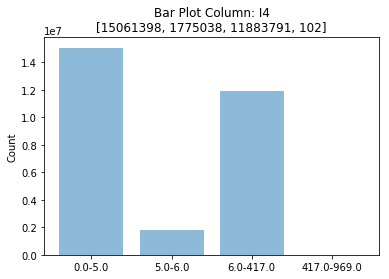

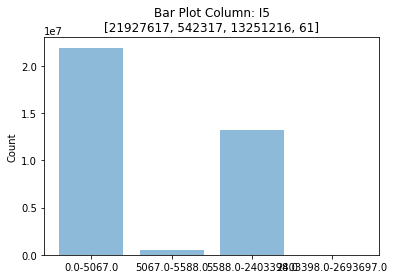

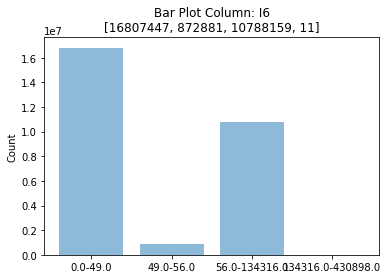

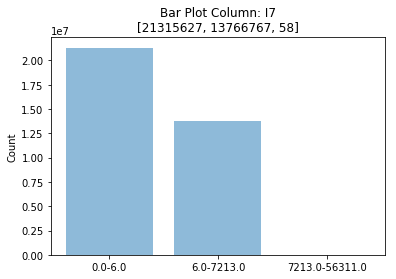

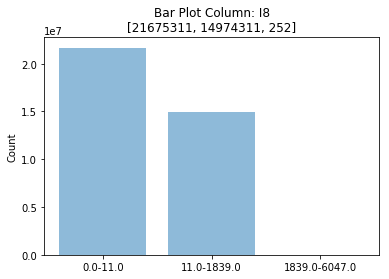

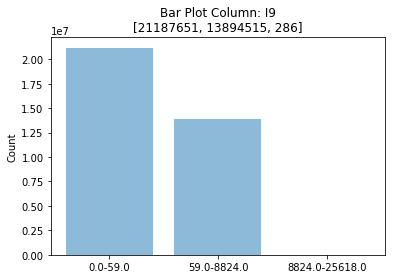

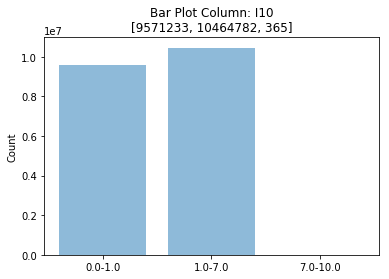

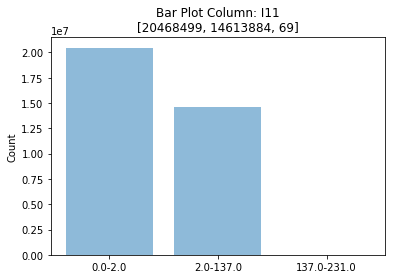

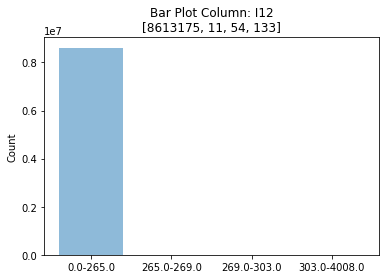

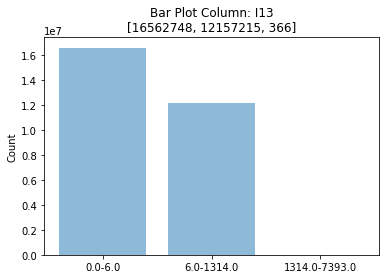

In [50]:
for j, field in enumerate(NUM_FIELDS):
    N = len(buckets[j])
    index = np.arange(N)
    bar_width = 0.95
    labels = []

    for i in range(N):
        labels.append(str(splits[j][i]) + "-" + str(splits[j][i+1]))

    plt.bar(buckets[j], count_buckets[j], align='center', alpha=0.5)
    plt.ylabel('Count')
    plt.xticks(index, labels)   
    plt.title('Bar Plot Column: ' + field + '\n'+str(count_buckets[j]))
    plt.show()

* **Above plots show that most of the numeric features have outliers beyond the 75% percentile value on the right end but their count is much smaller compared to the other buckets.** 


* **There are not too many outliers for the Logistic Regression model estimates to be skewed by these values (relying on large sample asymptotics and invoking Central Limit Theorem!) and Decision Trees can anyways innately handle features with outliers.** Hence, we decided not to do any processing such as removing these outliers and retained them as is.  

* However, to be on the safe side we decided to use median (as mean will be skewed because of the outliers) for imputing the values and standardize the features by computing mean post imputation, as means calculated before imputation would be skewed.

### 2.12 Label Column: Dependent Variable

In [51]:
### Label Column Distribution 
start = time.time()
label1_count = sampleDF[['Label']].select(count(when(col('Label') == "1", 1))).head()[0]
label0_count = sampleDF[['Label']].select(count(when(col('Label') == "0", 1))).head()[0]
print("Number of rows with label = 1:", label1_count , '\n% of rows with label = 1:', np.round(label1_count*100/row_count,2), "%")
print("\nNumber of rows with label = 0:", label0_count , '\n% of rows with label = 0:', np.round(label0_count*100/row_count,2), "%")

print('\n...', time.time()-start, 'seconds.')

Number of rows with label = 1: 9395634 
% of rows with label = 1: 25.62 %

Number of rows with label = 0: 27272397 
% of rows with label = 0: 74.38 %

... 1.1030511856079102 seconds.


### 2.13 Data Transformation Steps based on EDA  

Based on our EDA on full train dataset, we decided to do the following transformations on columns:

#### A. Numerical Columns:

 **1. Imputing with medians**: 
    
 We decided to impute the missing values in the numeric features with the median value for each corresponding column. **The choice of median instead of mean is made due to the multiple large outliers on the high end that would have caused our mean values to be larger (skewed).** Note, that there is no need to impute the null values for the categorical features since one hot encoding will take care of the nulls later on. 
    
**2. Standardizing**: 
    
In the summary statistics, **we noticed that the numerical features have different ranges for each column, and thus we decided to standardize our data** (i.e. subtracting by mean and dividing by standard deviation of each column), in order to scale them. **Standardization would also help with our Logistic Regression algorithm to coverge faster and use regularization to determine importance of coefficients**.

#### B. Categorical Columns:

**1. Bucketing as 'High', 'Medium', 'Rare', 'Missing':**

The above analysis shows that some categorical variables have a high number of unique categories. Aditionally, the distribution of counts for most of the categorical variables is very skewed (i.e. some categories appear much more often than others). Considering this information, we decided to take the following approach to deal with categorical variables: 

Bucket the categories within each categorical column into 4 groups based on their occurence counts:

   * **High frequency**: categories that occur more times than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *more than 100 times*)
   * **Medium frequency**: categories that occur more times than 2% and less than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *50-100 times*)
   * **Low frequency**: categories that occur less times than 2% of the total row count (Example: if the total row count is 1000 -> categories that occur *less than 50 times*)
   * **Missing**: null occurencies (note: since there are a couple of categorical variables with significant percentages of null occurencies, we wanted to retain this information to see if it potentially creates some signal for our models)

**2. One Hot Encoding:**

Convert categorical features to numerical using *One-hot Encoding* as per the buckets obtained above for each column. Specifically, each categorical feature will be converted into 4 columns (`high`, `medium`, `low` and `missing`) that will have values of `1`'s and `0`'s denoting whether that record has a value for that categorical variable that belongs in one of the 4 buckets. This is an alternative data transformation method of categorical variables to numerical, instead of the traditional one-hot enconding. The choice for this method is based on the effort to retain all the information/signals from the categorical variables and at the same time reduce the dimensionality of the dataset compared to a traditional one-hot enconding transformation.

### PART D: DATA TRANSFORMATION ON TOY DATASET

#### 2.13.1 Impute nulls with medians

In [52]:
def impute_nulls(line, mean_or_median_dict):
    """
    Impute the null values of the numerical columns with the mean value of the column
    """
    features, label = line[0], line[1]
    imputed_features = []
    for i, value in enumerate(features):
        if i < 13: 
            if value == 'null':
                imputed_features.append(mean_or_median_dict[i])
            else:
                imputed_features.append(value)
        else: 
            imputed_features.append(value)
    return (imputed_features, int(label))

In [53]:
# getting the median with pandas because RDDs don't have a built-in function 
medians = toy_df_num.median().tolist()
median_dict_toy = dict(zip(mean_dict_toy.keys(), medians))

In [54]:
# imputing nulls with median 
imputedToyRDDCached = toyRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()

In [55]:
print(imputedToyRDDCached.take(1))

[([0.0, 478.0, 13.0, 4.0, 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 0.0, 4.0, '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.13.2 Standardize features 

In [56]:
def standardize(line, mean_dict, st_dev_dict):
    """
    Scale and center data round mean of each feature (mean=0, sd=1)
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if i < 13: 
            formated_features.append((value-mean_dict[i])/st_dev_dict[i])
        else: 
            formated_features.append(value)

    return (formated_features, label)

In [57]:
# TOY DATA 
normedToyRDDCached = imputedToyRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

#### 2.13.3 Bucketing Categorical features 

Below, we will demonstrate how the bucketing/one-hot encoding that was applied in a scalable manner to our Criteo dataset, using our toy dataset with 1000 rows.

We will use variable `C1` as an example to demonstrate the implementation. The analysis above showed that variable `C1` has 57 uniques categories, hence we will obtain the occurence counts for each of the 57 categories in `C1`. Each of these categories will then be placed in one of the 4 buckets mentioned above based on its occurence counts.

**Step 1**. Obtain the occurence counts for each category.

In [58]:
# C1 has var_position = 13
category_counts_C1 = normedToyRDDCached.map(lambda x: ( x[0][13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])

category_counts_C1.take(10)

[('05db9164', 485),
 ('68fd1e64', 146),
 ('5a9ed9b0', 103),
 ('8cf07265', 51),
 ('be589b51', 41),
 ('5bfa8ab5', 27),
 ('f473b8dc', 20),
 ('87552397', 15),
 ('39af2607', 13),
 ('9a89b36c', 9)]

**Step 2**. Classify each category into one of the 4 buckets mentioned above based on its occurence counts and broadcast this information. As we learned throughout the semester, broadcasted variables are very useful in cases where the programmer wants to pass a copy of some useful information to every node in an efficient manner. 

* `>=` 100 times (i.e. 10% of 1000 rows) -> *High frequency* 
* 20-100 times (i.e. 2-10% of 1000 rows) -> *Medium frequency* 
* `<`20 times (i.e. 2% of 1000 rows) -> *Low frequency* 
* `==` 'null' -> *Missing*


In [59]:
# applying on C1 only 
high_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
medium_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
low_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

In [60]:
# C1 
print('High frequency categories: {} \n'.format(high_frequency_categorices_C1.value))
print('Medium frequency categories: {} \n'.format(medium_frequency_categorices_C1.value))
print('Low frequency categories: {} \n'.format(low_frequency_categorices_C1.value))

High frequency categories: ['05db9164', '68fd1e64', '5a9ed9b0'] 

Medium frequency categories: ['8cf07265', 'be589b51', '5bfa8ab5', 'f473b8dc'] 

Low frequency categories: ['87552397', '39af2607', '9a89b36c', 'ae82ea21', '241546e0', '09ca0b81', '17f69355', '439a44a4', '1464facd', 'fb174e6b', 'b455c6d7', '75ac2fe6', '45cb84c9', '28e55712', '7e5c2ff4', 'd4b08d58', 'da4eff0f', 'c974c00b', '42a16b9a', '3b65d647', 'fbc55dae', 'b19f768d', '2ebc17d3', '37d3940e', '5ebc3192', '3c9d8785', '9684fd4d', 'a14cf13a', '49807078', 'dac91c28', '439f942d', '41edac3d', '813d7135', '06584483', '291b7ba2', '40e1377d', 'e8ef605b', '394fc830', 'eb6dcae0', 'bfb430af', '5d7d2fe8', 'c79f9af8', '88abfaf6', '426610d2', '18988050', '0a16e1d4', '92fb1d87', 'c71ae391', 'abca0bad', '46300ee3'] 



**Step 3.** Applying a homegrown one-hot encoding implementation as explained above. 

In [61]:
# C1 example: the new columns of our dataset now are
FIELDS_NEW_C1 = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',          # numerical 
          'High_Freq_C1','Medium_Freq_C1','Low_Freq_C1','Missing_C1',      # categorical 
          'Label']                        

In [62]:
def OHE_transform(line, cat_var_position, high_frequency_categorices, medium_frequency_categorices, low_frequency_categorices):
    """
    One hot encoding transformation of an RDD 
    using the high/medium/low/missing logic
    
    returns: (ohe_transformed_features, label)
    """
    features, label = line[0], line[1]
    cat_features = []
    num_features = []
    for i, value in enumerate(features):
        if i > 12 and i < 39: 
            cat_features.append(value)
        else:
            num_features.append(value)

    # define the cat_var_position here 
    high_freq = 1 if any(i in cat_features[cat_var_position] for i in high_frequency_categorices.value) else 0
    medium_freq = 1 if any(i in cat_features[cat_var_position] for i in medium_frequency_categorices.value) else 0
    low_freq = 1 if any(i in cat_features[cat_var_position] for i in low_frequency_categorices.value) else 0
    missing = 1 if any(i in cat_features[cat_var_position] for i in ['null']) else 0
    ohe_features = [high_freq] + [medium_freq] + [low_freq] + [missing]

    return (num_features + ohe_features, label)

In [63]:
# transforming RDD for C1 
var_position = 13
cat_var_position = 0
oheTrasformedToyRDDCached_C1 = normedToyRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C1, medium_frequency_categorices_C1, low_frequency_categorices_C1)).cache()

In [64]:
print(oheTrasformedToyRDDCached_C1.take(1))

[([-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, -0.3695533056937703, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, -0.18844495754595464, -0.370231874980293, 1, 0, 0, 0], 1)]


**Step 4**. Transform all 26 categorical features

In [65]:
oheTrasformedToyRDDCached_all = oheTrasformedToyRDDCached_C1

for cat_var_position in list(range(1,26)):
    
    category_counts_C_i = normedToyRDDCached.map(lambda x: ( x[0][cat_var_position+13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])
    
    high_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
    medium_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
    low_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

    oheTrasformedToyRDDCached_C_i = normedToyRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C_i, medium_frequency_categorices_C_i, low_frequency_categorices_C_i)).cache()
    
    oheTrasformedToyRDDCached_all = oheTrasformedToyRDDCached_all.zip(oheTrasformedToyRDDCached_C_i.map(lambda x: x[0][13:])).map(lambda x: (x[0][0]+x[1], x[0][1]))

In [66]:
print(oheTrasformedToyRDDCached_all.take(1))

[([-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, -0.3695533056937703, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, -0.18844495754595464, -0.370231874980293, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], 1)]


In [67]:
cat_col_names = []

for i in list(range(1,27)):
    cat_col_names.append('High_Freq_C'+str(i))
    cat_col_names.append('Medium_Freq_C'+str(i))
    cat_col_names.append('Low_Freq_C'+str(i))
    cat_col_names.append('Missing'+str(i))
    
FIELDS_NEW = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13'] + cat_col_names + ['Label']

In [68]:
print(FIELDS_NEW)

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'High_Freq_C1', 'Medium_Freq_C1', 'Low_Freq_C1', 'Missing1', 'High_Freq_C2', 'Medium_Freq_C2', 'Low_Freq_C2', 'Missing2', 'High_Freq_C3', 'Medium_Freq_C3', 'Low_Freq_C3', 'Missing3', 'High_Freq_C4', 'Medium_Freq_C4', 'Low_Freq_C4', 'Missing4', 'High_Freq_C5', 'Medium_Freq_C5', 'Low_Freq_C5', 'Missing5', 'High_Freq_C6', 'Medium_Freq_C6', 'Low_Freq_C6', 'Missing6', 'High_Freq_C7', 'Medium_Freq_C7', 'Low_Freq_C7', 'Missing7', 'High_Freq_C8', 'Medium_Freq_C8', 'Low_Freq_C8', 'Missing8', 'High_Freq_C9', 'Medium_Freq_C9', 'Low_Freq_C9', 'Missing9', 'High_Freq_C10', 'Medium_Freq_C10', 'Low_Freq_C10', 'Missing10', 'High_Freq_C11', 'Medium_Freq_C11', 'Low_Freq_C11', 'Missing11', 'High_Freq_C12', 'Medium_Freq_C12', 'Low_Freq_C12', 'Missing12', 'High_Freq_C13', 'Medium_Freq_C13', 'Low_Freq_C13', 'Missing13', 'High_Freq_C14', 'Medium_Freq_C14', 'Low_Freq_C14', 'Missing14', 'High_Freq_C15', 'Medium_Freq_C15', 'Low_Fr

### ...Caching toy train and test RDDs post data transformations

In [69]:
toyTrainRDD = oheTrasformedToyRDDCached_all

We will apply the same data transformations to the toy held-out dataset, using the parameters from the train toy set (i.e. median for imputation, mean and st. deviation for standardization).

### ...Data transformation of the toy Test Dataset

In [70]:
# transforming the test toy data using the train data parameters 
# toy_testRDD = sc.textFile('data/toy_test300.txt')
toyTestRDDCached = toy_testRDD.map(parse).map(edit_data_types).cache()
imputedToyTestRDDCached = toyTestRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()
normedToyTestRDDCached = imputedToyTestRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

In [71]:
# transforming categorical features for test toy RDD using parameters obtained for train RDDs 

# initialize to get C1
var_position = 13
cat_var_position = 0
oheTrasformedToyTestRDDCached_C1 = normedToyTestRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C1, medium_frequency_categorices_C1, low_frequency_categorices_C1)).cache()

# get transformed features for full data 
oheTrasformedToyTestRDDCached_all = oheTrasformedToyTestRDDCached_C1

for cat_var_position in list(range(1,26)):
    
    category_counts_C_i = normedToyRDDCached.map(lambda x: ( x[0][cat_var_position+13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])
    
    high_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
    medium_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
    low_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

    oheTrasformedToyTestRDDCached_C_i = normedToyTestRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C_i, medium_frequency_categorices_C_i, low_frequency_categorices_C_i)).cache()
    
    oheTrasformedToyTestRDDCached_all = oheTrasformedToyTestRDDCached_all.zip(oheTrasformedToyTestRDDCached_C_i.map(lambda x: x[0][13:])).map(lambda x: (x[0][0]+x[1], x[0][1]))

In [72]:
toyTestRDD = oheTrasformedToyTestRDDCached_all

In [73]:
print(toyTestRDD.take(1))

[([-0.3718050070197415, -0.19538845905765978, -0.23945961131710256, -0.04609035610338022, -0.2527571739413964, -0.34605167169543277, -0.18066982273331073, -0.43992981858484737, -0.48851359420304374, 0.5068178388073282, -0.3643795000258798, -0.18844495754595464, -0.09211169117156807, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 0)]


### ...Transform toy RDD train and test sets to pandas DataFrames:
These will be used in section 3B for training and validating the homegrown Random Forest implementation in Python.

In [74]:
toyTrainRDDtoPandas = toyTrainRDD.map(null_to_nan).map(lambda x: np.append(x[0], [x[1]])).collect()
toyTestRDDtoPandas = toyTestRDD.map(null_to_nan).map(lambda x: np.append(x[0], [x[1]])).collect()

toy_train_df = pd.DataFrame(toyTrainRDDtoPandas, columns=FIELDS_NEW) 
toy_test_df = pd.DataFrame(toyTestRDDtoPandas, columns=FIELDS_NEW) 

In [75]:
toy_train_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,Missing24,High_Freq_C25,Medium_Freq_C25,Low_Freq_C25,Missing25,High_Freq_C26,Medium_Freq_C26,Low_Freq_C26,Missing26,Label
0,-0.543361,0.858097,-0.128395,-0.369553,-0.214049,0.387381,-0.074035,0.002878,1.072977,-0.911273,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.200249,-0.270975,-0.283886,-0.369553,-0.245264,-0.373506,-0.170006,-0.882738,-0.524351,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.371805,-0.268613,-0.394950,0.061731,-0.255540,-0.114648,-0.191333,-0.144724,-0.483394,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,-0.543361,0.151837,-0.261673,0.061731,-0.248304,-0.110726,-0.127353,2.290720,1.236805,-0.911273,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,-0.200249,-0.266251,-0.195034,2.110329,-0.246805,-0.259765,-0.074035,2.143117,0.709482,0.506818,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [76]:
toy_test_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,Missing24,High_Freq_C25,Medium_Freq_C25,Low_Freq_C25,Missing25,High_Freq_C26,Medium_Freq_C26,Low_Freq_C26,Missing26,Label
0,-0.371805,-0.195388,-0.239460,-0.046090,-0.252757,-0.346052,-0.180670,-0.439930,-0.488514,0.506818,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.371805,-0.268613,-0.394950,-0.369553,-0.224040,-0.263688,-0.191333,-0.808937,-0.452676,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.543361,-0.266251,-0.372737,-0.585195,-0.177867,-0.075427,0.875013,-0.661334,1.395514,-0.911273,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.371805,-0.270975,-0.328311,-0.369553,0.094833,0.587409,-0.180670,-0.735135,-0.073823,0.506818,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.371805,-0.270975,-0.350524,-0.369553,-0.224040,-0.263688,-0.159343,-0.956539,-0.324685,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## 3. Algorithm Explanation

### Goals for this section:

#### PART A: Logistic Regression

Build a home grown implementation of Logisitc Regression using RDDs

#### PART B: Random Forest

Build a home grown implementation of Random Forest using Python. 

### Why did we choose these two models?

Given scalability concerns and the need for feature selection, we decided to explore two independent models to assess the optimal performance. We also wanted to identify algorithms that have a history of success in the Spark framework for binary classification. Logistic Regression and Decision Trees met all of these criteria. Logistic Regession is highly scalable and combined with regularization could aid in feature selection. Decision trees have similar benefits and additionally require little pre-processing and any prior feature selection. We continued down these parallel paths to compare the performance of these models.

### Baseline: 

Our baseline is at 74.38% (which is majority of class 0 in train dataset). We will be bechmarking our models' accuracy and performance results in comparison with this baseline. 

### PART A: Logisitc Regression

### 3.1 Logistic Regression

### 1. Logistic Regression

Logistic Regression is a supervised machine learning approach designed for classification problems and where the goal is to predict a binary output variable. Other assumptions are that there is a linear relationship between the logit and each feature and that there are no extreme outliers in the continuous variables. There should be no autocorrelation between features as well.

### 2. Advantages of Logistic Regression

#### Why did we select LR for this dataset?

* We implemented Logistic Regression with Gradient Descent as it is a fast and scalable model that is easily deployed via the MapReduce Framework.
* LR’s Regularization features can also improve the generalizability of the model on an unseen dataset.
* Regularization may also help us determine the dataset’s most important features by assessing which ones are driven to zero.
* Batch gradient descent also allows us to scale the model.
* LR is a convex optimization algorithm, ensuring that we will find our global minimum.

### 3. Math

LR models the probability that each record belongs to a particular category. The sigmoid function (1 / (1+ np.exp(np.dot(X,theta)) gives us outputs between 0 and 1 for all values of X. We want to find the best weights that minimize the loss function.  Gradient descent increases and decreases weights until we find our global minimum and we can adjust our learning rate in optimizing the process. We then identify a threshold that predicts a class of 1 if the output probability is greater than this threshold.

### Logistic regression
Instead of fitting a line to the raw 1s and 0s of the data, logistic regression models the _probability_ that the outcome is 1 given the value of the predictor. Since probabilities have to be between 0 and 1, to do this we need a function that transforms our predictor variable (which in theory could range from −∞ to +∞) to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most appropriate choice when dealing with probabilities.

$$\textrm{theLogisticFunction}\thinspace(t) = \frac{1}{1 + e^{-t}}$$

### Probability, odds, and log-odds

$$\begin{alignat}{3}
\textrm{odds} & = e^{\textrm{log odds}} && = \frac{\textrm{probability}}{1 - \textrm{probability}} \\
\textrm{log odds} & = log(\textrm{odds}) && = log(\frac{\textrm{probability}}{1 - \textrm{probability}}) \\
\textrm{probability} & = \frac{\textrm{odds}}{1 + \textrm{odds}} && = \frac{e^{\textrm{log odds}}}{1 + e^{\textrm{log odds}}}
\end{alignat}$$

### 4. Summary:
We only ran the homegrown model for demonstrative purposes on the toy dataset so we are not directly using it for feature selection. But directionally the Lasso model did identify features with zero coefficients.  We have not yet removed outliers but have listed this under future work.

### 3.1.1 Homegrown Implementation of Logistic Regression

In [124]:
# Define the baseline model

BASELINE = np.array([0.25, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [125]:
# Compute log loss for Logisitc Regression
def LRLoss(cachedRDD, W):
    augmentedData = cachedRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: -x[1] * np.log(1/ (1 + np.exp(-(np.dot(x[0],W))))) - (1-x[1]) * np.log(1-(1/ (1 + np.exp(-(np.dot(x[0],W))))))).mean()
    return loss

In [126]:
# Compute the gradient for logistic regression (one step)
def GDUpdate(dataRDD, W, learningRate):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean()
    new_model = W - (learningRate * grad)
    return new_model

In [127]:
# Perform one Gradient Descent update with lasso regularization
def GDUpdate_Lasso(dataRDD, W, learningRate, regParam):

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    #new_model = None    
    wReg = np.sign(W)
    wReg[0] = 0  #set bias to zero
       
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean() + (wReg * regParam)
    new_model = W - (learningRate * grad)
    
    return new_model

In [128]:
new_model = GDUpdate_Lasso(toyTrainRDD, BASELINE, .1, .1)
print(new_model)

[ 2.21482350e-01  8.78383940e-03  1.60617231e-03  2.70828164e-03
  2.20410848e-03 -4.10809805e-03 -2.16382527e-03  2.29545974e-03
  3.52792570e-04  1.95465395e-03 -2.66581949e-03  9.38734141e-03
  5.07765951e-03 -5.47484142e-04 -2.08637552e-02 -4.71425336e-03
 -2.93964156e-03  0.00000000e+00 -2.80881211e-03 -8.91995988e-03
 -1.67888781e-02  0.00000000e+00  0.00000000e+00 -1.11140010e-03
 -2.74062500e-02 -1.11140010e-03  0.00000000e+00 -3.96502976e-03
 -2.45526203e-02 -1.11140010e-03 -2.28671260e-02 -2.85311206e-03
 -2.79741201e-03  0.00000000e+00 -2.69829322e-02 -1.53471791e-03
  0.00000000e+00 -3.93316511e-03  0.00000000e+00  1.34704973e-05
 -2.85311206e-02  0.00000000e+00 -2.05254141e-02 -4.68886516e-03
 -3.30337086e-03  0.00000000e+00 -2.85176501e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.44301242e-03  0.00000000e+00
 -2.10746377e-02  0.00000000e+00  0.00000000e+00 -1.23835403e-04
 -2.83938147e-02  0.00000000e+00  0.00000000e+00 -2.08549431e-03
 -2.64321558e-02 -1.11140

In [152]:
def predict_and_score(dataRDD, W, threshold):
    """Assess peformance of current models"""
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
        
    sc.broadcast(W)
    sc.broadcast(threshold)

    def predict_label(line):
        features = line[0]
        label = line[1]
        pred = None
        z = np.dot(features,W)
        prob = np.divide(1.0, (1.0 + np.exp(-z)))
        if prob > threshold:
            pred = float(1.0)
        else:
            pred = float(0.0)
        return label, pred
        
    def map_accuracy(line):
        label_actual = line[0]        
        label_pred = line[1]
        
        if label_actual == 1.0 and label_pred == 1.0:
            return "TP", 1.0
        elif label_actual == 1.0 and label_pred == 0.0:
            return "FN", 1.0
        elif label_actual == 0.0 and label_pred == 0.0:
            return "TN", 1.0
        else:
            if label_actual == 0.0 and label_pred == 1.0:
                return "FP", 1.0
    
    scores = augmentedData.map(predict_label).map(map_accuracy).reduceByKey(lambda x, y: x + y).collect()
    
    TP, FN, TN, FP = 0.0, 0.0, 0.0, 0.0

    for i in scores:
        if i[0] == 'TP':
            TP = i[1]
        elif i[0] == 'FN':
            FN = i[1]
        elif i[0] == 'TN':
            TN = i[1]
        else:
            if i[0] == 'FP':
                FP = i[1]

    if TP != 0.0:
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = 2*((precision*recall)/(precision+recall))
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        false_positive_rate = FP/(FP+TN)
        
    else:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
        accuracy = 0.0
        false_positive_rate = 0.0

#     print("scores=", scores)
#     print("True Positives=", TP)
#     print("False Negatives=", FN)
#     print("True Negatives=", TN)
#     print("False Positives=", FP)
#     print("Precision=", precision)
#     print("Recall=", recall)
#     print("F1_score=", f1_score)
#     print('Accuracy=', accuracy)

    return accuracy, precision, recall, f1_score, false_positive_rate
    

In [153]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = True):
    """
    Perform nSteps iterations of Logistic Regression gradient descent and 
    track performance metrics on the test and train set. 
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    accuracies, f1_scores, precisions, recalls, false_positive_rates = [], [], [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## CORE CODE #############
        
        new_model = GDUpdate(trainRDD, model, learningRate=0.1)
        training_loss = LRLoss(trainRDD, new_model)
        test_loss = LRLoss(testRDD, new_model)
        accuracy, precision, recall, f1_score, false_positive_rate = predict_and_score(toyTrainRDD, new_model, threshold=.25)
        
        model = new_model
        
        ############## (END) CORE CODE #############
        
        # keep track of metrics for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
        false_positive_rates.append(false_positive_rate)
        
        # console output
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"False Positive Rate: {false_positive_rate}")
            print(f"Model: {[np.round(w,3) for w in model]}")
    return train_history, test_history, model_history, accuracies, f1_scores, precisions, recalls, false_positive_rates

### 3.1.2 Training LR on toy train dataset for 10 interations

In [154]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
logLossTrain, logLossTest, model_history, accuracy, f1_score, precision, recall, false_positive_rate = GradientDescent(toyTrainRDD, toyTestRDD, wInit, nSteps = 10)
print(f"\n... trained {10} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6251176967003571
test loss: 0.6453071760039515
Accuracy: 0.277
Precision: 0.277
Recall: 1.0
False Positive Rate: 1.0
Model: [0.221, 0.009, 0.002, 0.003, 0.002, -0.004, -0.002, 0.002, 0.0, 0.002, -0.003, 0.009, 0.005, -0.001, -0.021, -0.005, -0.003, 0.0, -0.003, -0.009, -0.017, 0.0, 0.0, -0.001, -0.027, -0.001, 0.0, -0.004, -0.025, -0.001, -0.023, -0.003, -0.003, 0.0, -0.027, -0.002, 0.0, -0.004, 0.0, 0.0, -0.029, 0.0, -0.021, -0.005, -0.003, 0.0, -0.029, 0.0, 0.0, 0.0, -0.007, 0.0, -0.021, 0.0, 0.0, -0.0, -0.028, 0.0, 0.0, -0.002, -0.026, -0.001, 0.0, -0.0, -0.028, 0.0, -0.024, -0.003, -0.002, 0.0, 0.0, -0.001, -0.028, 0.0, 0.0, -0.002, -0.026, -0.001, -0.019, -0.009, 0.0, 0.0, 0.0, -0.005, -0.023, 0.0, -0.023, -0.0, -0.006, -0.012, -0.029, 0.0, 0.0, -0.012, 0.0, -0.002, -0.026, -0.001, -0.025, -0.003, -0.0, -0.022, -0.021, -0.007, -0.001, 0.0, 0.0, -0.008, -0.021, -0.001, -0.02, -0.008, -0.001, -0.012, -0.012, -0.002, -0.015, -0.012]
----------
STEP

----------
STEP: 10
training loss: 0.5767396890233853
test loss: 0.5798322600871825
Accuracy: 0.369
Precision: 0.29701834862385323
Recall: 0.9350180505415162
False Positive Rate: 0.8478561549100968
Model: [0.194, 0.043, 0.015, 0.011, 0.003, -0.038, -0.031, 0.013, 0.001, 0.01, 0.02, 0.076, 0.016, -0.023, -0.04, -0.016, -0.001, 0.0, -0.002, -0.013, -0.041, 0.0, 0.0, -0.004, -0.052, -0.004, 0.0, -0.014, -0.042, -0.004, -0.04, -0.007, -0.01, 0.0, -0.059, 0.003, 0.0, -0.009, 0.0, 0.006, -0.062, 0.0, -0.031, -0.012, -0.013, 0.0, -0.056, 0.0, 0.0, 0.0, -0.024, 0.0, -0.032, 0.0, 0.0, 0.005, -0.061, 0.0, 0.0, -0.008, -0.048, -0.004, 0.0, 0.005, -0.061, 0.0, -0.045, -0.003, -0.008, 0.0, 0.0, -0.004, -0.053, 0.0, 0.0, -0.008, -0.048, -0.004, -0.025, -0.031, 0.0, 0.0, 0.0, -0.009, -0.047, 0.0, -0.045, 0.001, -0.012, -0.021, -0.056, 0.0, 0.0, -0.021, 0.0, -0.008, -0.048, -0.004, -0.049, -0.005, -0.002, -0.05, -0.033, -0.019, -0.005, 0.0, 0.0, -0.021, -0.035, -0.004, -0.038, -0.017, -0.001, -0.021, 

### 3.1.3 Visualizing Loss and Accuracy Curves

In [155]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss') #trainLoss[1:]
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()

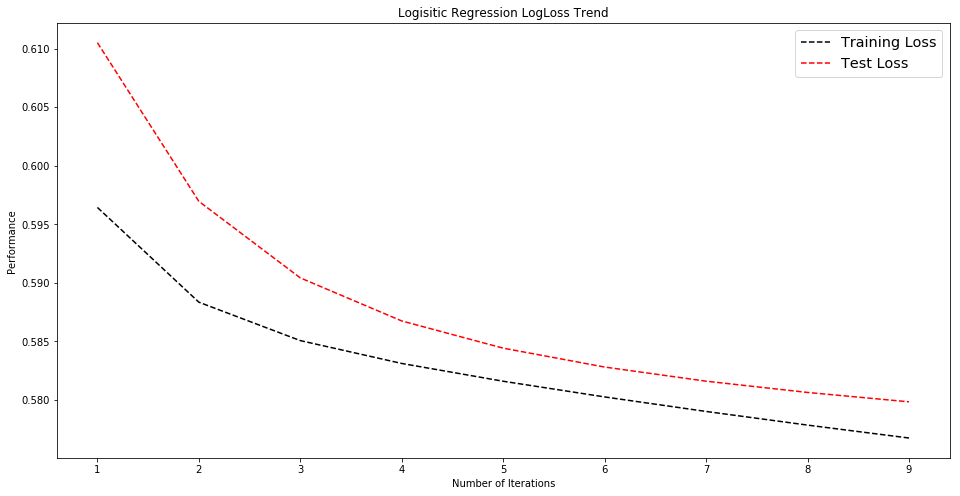

In [156]:
LR_LogLoss_lasso = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_LogLoss_lasso

In [157]:
def plotPerformance(accuracy, f1_score, title = None):
    """
    Helper function for plotting.    
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(accuracy)))[1:]
    ax.plot(x, accuracy[1:], 'r--', label='Accuracy')
    ax.plot(x, f1_score[1:], 'k--', label='F1_score')
    #ax.plot(x, precision[1:], 'g--', label='Precision')
    #ax.plot(x, recall[1:], 'b--', label='Recall')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()
    
    #precision, recall

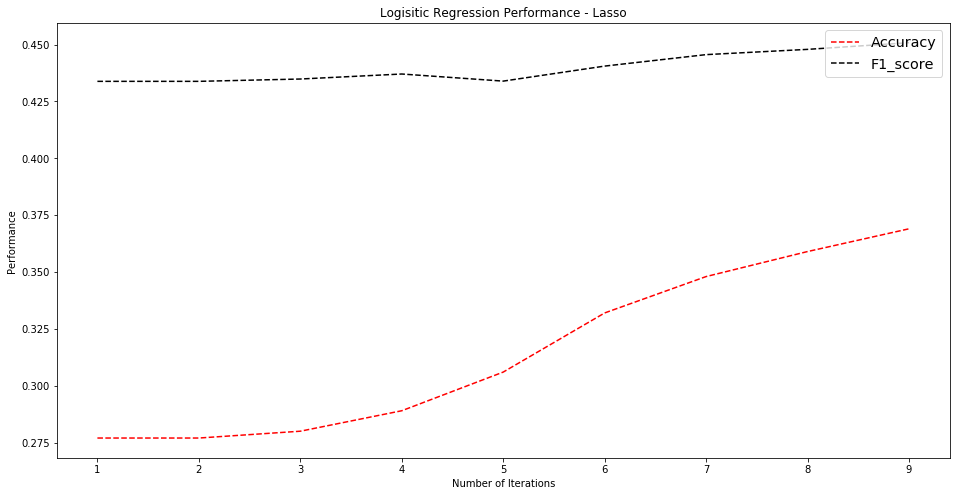

In [159]:
LR_performance_lasso = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - Lasso')
LR_performance_lasso

### PART B: Random Forest

### 3.2 Decision Tree and Random Forest

### 3.2.1 Decision Tree Introduction

### 1. Decision Trees (DT)

> Decision Tree is a **supervised machine learning approach whose goal is to recursively partition the world into homogeneous zones (i.e., zones where the target value is constant)**. Machine learning model built using DTs can be easily depicted using a tree (typically a binary split tree) where the end **target label can be predicted by traversing down the tree following the tree's decision rules at each node and reaching a terminal which gives the predicted output**. 

### 2. Types of DTs

> * **Classification trees:** Tree models where the target variable can take a finite set of values. Leaves represent class labels. Branches represent conjunctions of features that lead to those class labels.
* **Regression trees:** Decision trees where the target variable can take continuous values (typically real numbers)

### 3. Building a Decision Tree

> #### Representation of a DT
**A decision tree represents a hierarchical segmentation of the data. The entire data set is partitioned into two or more segments by applying a series of simple rules over input variable(s)** ex. Age less than 10 -> samples go to left branch; greater than 10 go to right branch. Each resulting segment can be further partitioned into subsegments, and so on. Since each sample belongs to only one partition, these are disjoint sets and the tree model can be thought of as the sum of all these regions.
* Root node: The original segment 
* Nodes: The segments
* Leaf nodes/leaves/terminals: Final segments (target labels)



> #### How are features selected for splitting nodes?

> * We use summary statistics to recursively partition our world into zones. Different criterion can be used for evaluating which features provide the most optimal split for a node. Ex. For regression trees, reduction in variance weighted by the size of child nodes is compared with variance of the node prior to split. **In classification problems, measures such as Entropy, Information Gain and Gini Index are used to compare the purity of nodes before and after splits to determine if a feature is the most optimal feature for a split**. Nodes with higher purity are preferred (all labels are of the same class) over impure nodes (ex. 50-50 are the most impure).


> * Building a DT can be thought of as **an optimization problem **- finding the optimal regions for split using rules and the optimal values (prediction value) to represent the samples in a terminal node/zones. Since solving for both at the same time is difficult, a greedy iterative approach is taken. **In the greedy approach, whenever a split is made the feature which provides the best split at the current point of time is chosen** and does not do a look ahead to see if the split selected in the current step along with the previous step provide the most optimal step or not. Hence, it is possible that the DT fit might not be the most optimal DT for a given model. 

> #### How are output values for prediction determined? 

> * **For regression problems**, summary statistics such as mean and variance are used. ex. For centrality: zones are summarized using mean value (depending on the loss function) and for spread: quality of the splits is characterized using the variance.


> * **For classification problems**, majority of class labels is taken to represent the target label for a terminal node (for models where output label is needed) where as probability of a class is taken as the output for problems like binomial logistic regression).

### 4. Advantages of Decision Trees

> #### Why did we select DTs for this dataset?
   * Can work with categorical (ordinal or nominal) and numerical features - Both kinds of features are present in this dataset
   * Can work with features of varying scales - Doesnt require standardizing data.
   * Can work with missing values - There are quite a few columns with missing features in this dataset.
   * Useful for feature selection - There are a large number of features after data transformation and their importance needs to be decided.
   * Ensemble of trees can be used to reduce variance in prediction and get higher accuracy. 
   * Highly scalable and amenable to distributed computing using Map Reduce framework.
   * Very few hyperparameters need to be tuned to get efficient ML models.
   
### 5. Ensemble of Decision Trees

> Even though DTs have all these advantages that make them suitable for a wide variety of problems, **they are highly susceptible to overfitting** if the depth of the tree is not controlled. To combat this and **reduce variance across models at the cost of little bias and interpretability (bias-variance tradeoff), an ensemble of DTs is built**. That is, multiple trees are built on samples of dataset and the average (or majority in case of classification) of all these trees is taken to determine the final predicted value. Doing this reduces the variance, even if the depth of the tree is not controlled, as a lot of trees are being averaged. 

### 6. Advantages of Various Sampling Methods for Ensembles:

> There are several ways different samples from the dataset can be selected to build these ensemble of  trees:

> * **Bootstrapping or Bagging**: When multiple random samples are drawn from the dataset, where each sample approximately contains 2/3 rds of the dataset. Even though bagging reduces the variance to an extent, it is not as effective as all features are available for each node while splitting. Hence, all the trees fit will look similar, not reducing the variance to a large extent. 
    
    
> * **Random Forest **- Bagging with random feature selection: Random forest deals with the problem of similar trees of Bagging by allowing only **a random subsample of the features (generally as many as square root of no. of features available) for each node to consider for further splitting.** This way trees fit are all different and provide a significant decrease in variance of the model. **Trees are built independent of each other**. 
    
    
> * **Boosting**: Boosting even though uses the entire dataset it is more effective in reducing variance by deciding to fit trees in a sequential manner, where each tree is fit on the previously fit tree's residuals. Overfitting is avoided and efficient models are built by tuning various hyperparameters such as: restricted number of trees, learning rates and number of splits used to build the tree at each stage.  **Trees are built in a sequential manner** depending on the output of  previous stages trees built. Boosted trees have been proven to reduce variance in DTs by a large margin. 


### 7. Examples of Decision Trees

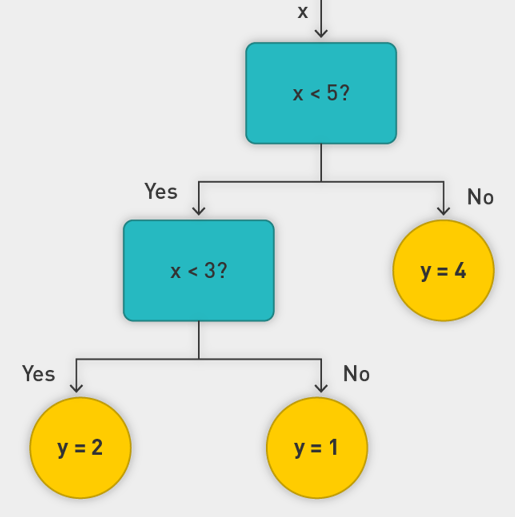

In [10]:
# display example tree
Image(filename="image_2_sample_tree.png", width=300,height=200)

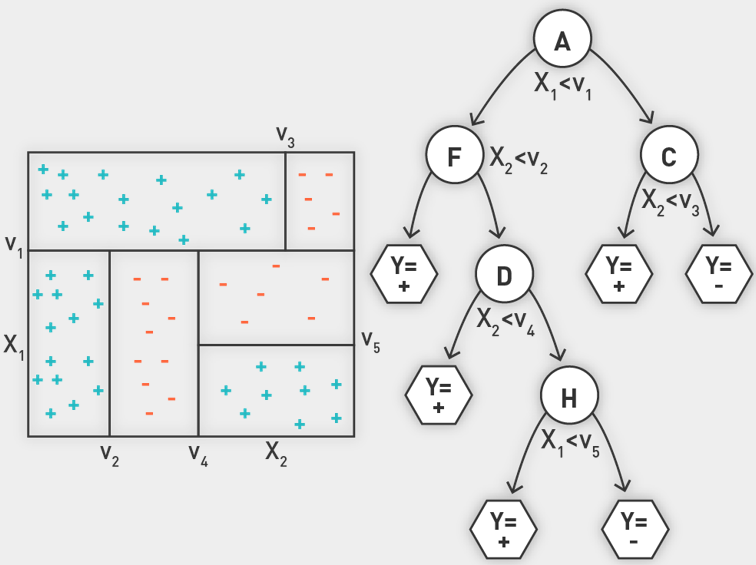

In [11]:
# display example tree
Image(filename="image_4_sample_tree.png", width=500,height=400)

### 3.2.2 Homegrown Implementation of RF 

### Goal: Build a binary classification tree for prediction of label = 0 or 1 using transformed input feature space

**Note**: DT built below is built as a classification tree where it predicts as output the label and LR code shown above predicts the probability of output class = 1 as a Binomial logistic regression. Note the difference: DT: lable vs LR: probability of label 

### 1. Inputs to DT

> * **Inputs to DT need to be numerical**. Hence, categorical features need to transformed into numerical features as well. Based on EDA and **data transformation steps taken in Section 2 on toy train and test datasets, we will be using these datasets** to train and validate random forest model on toy dataset. 


> * As a recap, numerical features I1 to I13 are imputed with medians and standardized while categorical columns C1 to C26 are one hot encoded as 'High', 'Medium',  'Rare' and 'Missing' make the** total number of columns = 13 + 26x4 = 104 + 13 = 117 with one column for 'Label' valued 0 or 1**. 

> Alternate Strategies for Data Transformation:

> 1. **Binning numeric columns into buckets** based on equi-distant bins or quantiles. This would help reduce the number of values that need to be checked and compared for splitting. 

> 2. **Breiman's Theorem for categorical columns**: where the categories in a column are  arranged in ascending order of probability of output label = 1, calculated by grouping rows based on the category and counting number of rows with output label = 1 divide by total number of records in each category. That is, features are bucketed based on their purity values. 

### 2. Data Structure Representation of DT

> **A nested dictionary** was used to represent decision trees being built with keys as follows: 

>     {'index': index of feature for splitting, 
>     'value': value at which to split, 
>     'left' : left_child after split or output label, 
>     'right': right_child after split or output label}

> It is a nested dictionary as the **'left' and 'right' keys could themselves have dictionaries as values if the left and right nodes are further branched or are output labels if terminal nodes**. Root node is presented as the first index and the tree can be traversed till a terminal node is reached to get the predicted label. 

> **Sample Decision Tree Nested Dictionary:**

>     {'index': 5, 
>      'value': 12.0,
>      'left': {'index': 0, 'value': 3.0, 'left': 0.0, 'right': 1.0}, 
>      'right': {'index': 2, 'value': 2.0, 'left': 0.0, right': 0.0}}


 > Trees were further processed for easy visualization of binary trees as graphs. Ex. digraph for above example DT is given below: 
 
> **Sample Decision Tree as Graph:**
 
>        digraph G {
>        D0_I6 -> D1_I1  [label="L 12.0"];
>        D1_I1 -> "D2_Class_0.0"  [label="L 3.0"];
>        D1_I1 -> "D2_Class_1.0"  [label="R 3.0"];
>        D0_I6 -> D1_I3  [label="R 12.0"];
>        D1_I3 -> "D2_Class_0.0"  [label="L 2.0"];
>        D1_I3 -> "D2_Class_0.0"  [label="R 2.0"];}
 
 
### 3. Building DT

There are three major tasks in building a DT: 

 > **1. Splitting of Nodes**: 
 
>  Gini Index has been used here to determine which feature provides the best split at a given point. **Gini index for a node is the sum of px(1-p) for all classes in output label**. 
 
        ex: p for class 1 in a node => p = (number of records of class=1)/total_records_in_node
 
 > Gini Index is calculated for both left and right child nodes after splitting and their weighted sum is taken based on the number of records in each child node after splitting. This exercise is repeated for every distinct set of values that a feature has in the given dataset for root node or number of records present in a node post split. Of all these values, the value which gives the best split is chosen for a node. 
 
 > Similarly, this exercise is repeated for all features available at the curren time for splitting a node (as it is a random forest, not all features will be present all the time for a split!) and the best feature among these is chosen as the feature and its value on which the next best split will be done. 
 
 
 > **2. Stopping Criterion**:
 
 > Two stopping criterion have been used for building DTs:
 
 > **Stopping criterion for expansion of a node**: If child node needs to be made a terminal because the number of records <= min.size of a node, stopping criteria is met and the node is made a terminal. 

> **Stopping criterion for building a DT:** Building a DT will be stopped if the stopping criterion for DT is met: ie. current depth > max.depth allowed. 

 > **3. Output Label for Terminal Nodes**:
 
 > If the child node is a terminal, its output prediction label is determined by taking majority of the class labels present in the records at that node level. 
 
### 4. Tuning Hyperparameters used
 
   > 1. **Number of Trees:** Number of trees fit on a random sample of the dataset as it is an ensemble of trees
   
   > 2. **Max depth:** Stopping criterion for when the tree expansion should stop if current dept >= max. depth
   
   > 3. **Min. node size:** Stopping criterion for when a node should be made a terminal if n(node) >= min.size but when split the number of nodes in each of the child nodes is less than the min.size. 
   
   > 4. **Sample Size:** The % subsample taken from a fold randomly to build each tree. ex. if sample_size = 1, entire fold is taken. n(sub_sample) = sample_size x n(fold_size)
    
   > 5. **No. of random features:** Number of features available at any point of time for splitting a node - randomly chosen from the entire list of features. Number of random features is equal to square root of the total number of features available. n(random_features) = sqr_root(total_number_of_features) 

### 5. Testing and Validating Output: 

> Cross validation is used to divide toy train data into k folds (k=3,5 here) and for each fold, 'n_trees' number of trees are fit and their majority is taken for output label and accuracy calculated for each fold by comparing with actual labels. Accuracy across all folds for a given set of trees is calculated as well for toy train and test datasets. 

### 6. Pseudo-code:

> Pre-processing: Convert required numeric and categorical columns to the right data types and one hot encode as needed. Here, we will be using the transformed dataset from Section 2 for toy train and test. 

> #### Pseudo-code for RF:

> **Step 1:** Split dataset into k folds
            
> **Step 2:**  Build 'n_trees' number of trees for each k fold 

   > 1. Take a subsample of the fold based on 'sample_size'
   > 2. Build a Decision Tree for subsample (look at pseudo-code for DT)
   > 3. Append DT to list of trees
   > 4. Repeat steps 1-3 as many times as number of trees needed
            
> **Step 3:** Get predictions for each tree using the DT built
            
> **Step 4:** Get majority label as the predicted label of all n_trees prediction 

> **Step 5:** Calculate accuracy % for current fold by comparing with actual labels 

> **Step 6:** Repeat steps 1-5 for all folds 

> **Step 7:** Average accuracy for all folds as the final accuracy

> **Step 8:** Output list of important features in decreasing order of importance (ascending oder of Gini Index)


> #### Pseudo-code for DT:

> **Step 1:** Get a list of random features available for a split

> **Step 2:** For each feature, get distinct list of values in the current sample

> **Step 3:** For each value, divide the data into two groups based on value

> **Step 4:** Determine the value for which Gini Index is the best 

> **Step 5:** Repeat steps 2-4 for all features 

> **Step 6:** Choose feature and its value for which Gini Index is the lowest

> **Step 7:** Expand DT by adding this node to DT along with its two groups with the keys 'index', 'value' and 'groups' key. 

> **Step 8: Feature Selection**

    > 1. Maintain a global dictionary with the sum of gini index value for a feature across all trees and folds. 

    > 2. At the end of all iterations, this feature list can be returned in increasing order of gini index as part of feature selection to show variables importance.  

> **Step 9: Building Nodes**

    > 1. 'Remove 'groups' keys and replace with 'left' and 'right' keys. 
    > 2. Call recursively 'split' function on each of the groups to determine if 'left' and 'right' groups need to be  expanded further as nodes or create a terminal node for output labels.
    > 3. If child node needs to be branched, call 'split function recursively.
    > 4. If child node needs to be made a terminal because the number of records <= min.size of a node, stopping criteria is met and the node is made a terminal. 
    > 5. If the child node is a terminal, determine its output prediction label by taking majority of the class labels present in the records at that node level. 

> **Step 10:** End building DT if the stopping criterion for DT is met: ie. current depth > max.depth allowed. 

### 7. List of Important Functions Code:

> Listing some of the important functions for building a tree and their function calls. Please refer to the code below for all functions code and their algorithm details.

> #### Split a dataset based on an attribute and an attribute value

        def test_split(index, value, dataset):
            for row in dataset:
                if row[index] < value:
                    left.append(row)
                else:
                    right.append(row)
            return left, right


> #### Calculate the Gini index for a split dataset

        def gini_index(groups, classes): 
                # classes: number of output/label classes
                # number of split branches at a split 
                # ex. if groups = 2, meaning left and right node of the splits

                # count all samples at split point
                # total number of samples in left and right nodes 
                n_instances = float(sum([len(group) for group in groups]))
                # sum weighted Gini index for each group
                gini = 0.0
                for group in groups:
                    size = float(len(group))
                    # avoid divide by zero - if there are no samples in a node
                    if size == 0: 
                        continue
                    score = 0.0
                    # score the group based on the score for each class
                    node_labels = [row[-1] for row in group]
                    for class_val in classes:
                        # count the no. of samples of class = 1,0 etc. 
                        p = node_labels.count(class_val) / size
                        # calculate unweighted gini index
                        score += p * (1-p)
                    # weight the group score by its relative size
                    # calculate gini index by weighing by the number of instances
                    gini += score * (size / n_instances)
                return gini
 
> #### Select the best split point for a dataset

        def get_split(dataset, n_features):
            class_values = list(set(row[-1] for row in dataset))
            b_index, b_value, b_score, b_groups = 999, 999, 999, None
            features = list()
            while len(features) < n_features:
                index = randrange(len(dataset[0])-1)
                if index not in features:
                    features.append(index)
            for index in features:
                # Get unique set of values for a feature (index)
                unique_values = set([row[index] for row in dataset])
                # use test split to get the distribution of nodes for each value 
                # get gini index of this test split 
                for value in unique_values:
                    # groups here are the left and right node samples after splitting on the value
                    groups = test_split(index, value, dataset)
                    gini = gini_index(groups, class_values)
                    if gini < b_score:
                        b_index, b_value, b_score, b_groups = index, value, gini, groups
            # returns a node with the index with which it has to be split, value and two groups after split
            features_importance[str(FIELDS[b_index])] += float(b_score)
            return {'index':b_index, 'value':b_value, 'groups':b_groups}
 

> #### Build a decision tree

        def build_tree(train, max_depth, min_size, n_features):
            root = get_split(train, n_features)
            # split is called on the root node to iteratively build the tree
            split(root, max_depth, min_size, n_features, 1)
            return root # this will have the entire tree


> #### Create a terminal node 

        def to_terminal(group):
            outcomes = [row[-1] for row in group]
            # set the label of the terminal node to be the dominant label of the node samples based on count
            return max(set(outcomes), key=outcomes.count)
 
> #### Create child splits for a node or make terminal

        def split(node, max_depth, min_size, n_features, depth):
            left, right = node['groups']
            del(node['groups'])
            # check for a no split
            if not left or not right:
                node['left'] = node['right'] = to_terminal(left + right)
                return
            # check for max depth
            if depth >= max_depth:
                node['left'], node['right'] = to_terminal(left), to_terminal(right)
                return
            # process left child
            if len(left) <= min_size:
                node['left'] = to_terminal(left)
            else:
                node['left'] = get_split(left, n_features)
                split(node['left'], max_depth, min_size, n_features, depth+1)
            # process right child
            if len(right) <= min_size:
                node['right'] = to_terminal(right)
            else:
                node['right'] = get_split(right, n_features)
                split(node['right'], max_depth, min_size, n_features, depth+1)  
            
### 8. Complete Homegrown Implementation of RF and DT using Python

In [78]:
# Using transformed toy datasets from above as pandas Dataframes
toy_dataset = toy_train_df.values.tolist()
toy_test_dataset = toy_test_df.values.tolist()

print(toy_dataset[0])
print(toy_test_dataset[0])

[-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, -0.3695533056937703, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, -0.18844495754595464, -0.370231874980293, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
[-0.3718050070197415, -0.19538845905765978, -0.23945961131710256, -0.04609035610338022, -0.2527571739413964, -0.34605167169543277, -0.18066982273331073, -0.43992981858484737, -0.48851359420304374, 0.50

In [165]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
        dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        if row[column] == 'null':
            row[column] = None
        else:
            row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    # useful if label column coming as categories
    for i, value in enumerate(unique):
        lookup[value] = i 
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            # gives one random number
            index = randrange(len(dataset_copy))
            # pop this random number from dataset
            fold.append(dataset_copy.pop(index))
        # add fold generated to list of folds
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    global flag
    folds = cross_validation_split(dataset, n_folds)
    x = int(len(dataset)*(n_folds-1)/n_folds)
    y = len(dataset[0])
    
    scores = list()
    for i,fold in enumerate(folds):
        train_set = list(folds)
        train_set.remove(fold)
        # Converting list of lists to list
        # Ex. converts [[1],[2],[3]] to [1,2,3]
        train_set = list(np.array(train_set).reshape(x,y))
        test_set = list()
        for row in fold:
            row_copy = list(row)
            # Setting the label to None in test set
            row_copy[-1] = None
            test_set.append(row_copy)
        trees, predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = np.round(accuracy_metric(actual, predicted),4)
        scores.append(accuracy)
        # using these flags so that the graph will have the nodes of one tree only and will not merge mutliple trees
        if i == len(folds)-1 and flag==1:
            decisiontree= trees[0]
            visit(decisiontree, 0) 
            #graph.write_png('decision_tree_graph.png')  
            #print("Sample Decision Tree Graph:\n\n", graph)
            flag = 2
            #print(yaml.dump(decisiontree, default_flow_style=False)) 
            #print("Sample Decision Tree Nested Dictionary:\n\n", decisiontree)
    return scores
 
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    # index here is the column index in dataset
    # value is the column/feature value based on which split has to be done 
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes): 
    # classes: number of output/label classes
    # number of split branches at a split 
    # ex. if groups = 2, meaning left and right node of the splits
    
    # count all samples at split point
    # total number of samples in left and right nodes 
    n_instances = float(np.sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero - if there are no samples in a node
        if size == 0: 
            continue
        score = 0.0
        # score the group based on the score for each class
        node_labels = [row[-1] for row in group]
        for class_val in classes:
            # count the no. of samples of class = 1,0 etc. 
            p = node_labels.count(class_val) / size
            # calculate unweighted gini index
            score += p * (1-p)
        # weight the group score by its relative size
        # calculate gini index by weighing by the number of instances
        gini += score * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        # Get unique set of values for a feature (index)
        unique_values = set([row[index] for row in dataset])
        # use test split to get the distribution of nodes for each value 
        # get gini index of this test split 
        for value in unique_values:
            # groups here are the left and right node samples after splitting on the value
            groups = test_split(index, value, dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, value, gini, groups
    # returns a node with the index with which it has to be split, value and two groups after split
    features_importance[str(FIELDS_NEW[b_index])] += float(b_score)
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    countone = np.sum(outcomes)
    countzero = len(outcomes) - countone
    # set the label of the terminal node to be the dominant label of the node samples based on count
    #return np.max(set(outcomes), key=outcomes.count)
    if(countone>countzero):
        return 1
    else:
        return 0

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    # split is called on the root node to iteratively build the tree
    split(root, max_depth, min_size, n_features, 1)
    return root # this will have the entire tree
 
# Make a prediction with a decision tree
def predict(node, row):
    # node here will be the root node
    if row[node['index']] < node['value']:
        # if the left branch is a node
        # call predict again to pass row down that node
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
        # else if it is terminal node, just return the label value
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = np.round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample
 
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    countone = np.sum(predictions)
    countzero = len(predictions) - countone
    # set the label of the terminal node to be the dominant label of the node samples based on count
    if(countone>countzero):
        return 1
    else:
        return 0
    #return max(set(predictions), key=predictions.count)

# Building a tree traversal and graph structure for visualization 
def visit(node, depth, parent = None):
    feature=node['index']
    feature = FIELDS_NEW[feature]
    feature_value=node['value']
    left_node = node['left']
    right_node = node['right']
    child_nodes = [left_node, right_node]
    
    if depth ==0:            
        node_root = "D"+str(depth)+"_"+str(feature)
    else:
        parent = FIELDS_NEW[parent]
        node_root = "D"+str(depth)+"_"+str(parent)
    
    # processing left_child
    if isinstance(left_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS_NEW[left_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label="L "+str(feature_value)))
        visit(left_node,depth+1, parent=left_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(left_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="L "+str(feature_value)))
    
    # processing right_child
    if isinstance(right_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS_NEW[right_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label='R '+str(feature_value)))
        visit(right_node,depth+1, parent=right_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(right_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="R "+str(feature_value)))


# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        decisiontree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(decisiontree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(trees, predictions)


# get_accuracy
def get_accuracy(dataset, n_trees, n_folds,  max_depth, min_size):
    accuracy_list = []
    global flag
    global features_importance
    print("N-folds:", n_folds, " Max_depth:", max_depth, " Min size:", min_size, "\n")
    for n_trees in number_of_trees:
        start = time.time()
        scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
        print('\nTrees: %d' % n_trees)
        print('Scores: %s' % scores)
        accuracy = np.round((np.sum(scores)/float(len(scores))),4)
        accuracy_list.append(accuracy)
        print('Mean Accuracy: %.3f%%' % accuracy)
        print('Training time:', time.time()-start, ' seconds')
    # setting flag back to 1 for next call of get_accuracy
    flag = 1
    features_importance = sorted(features_importance.items(), key=operator.itemgetter(1))
    features_importance = [(item[0],np.round(item[1],2)) for item in features_importance]
    print('\nTop 20 Features in decreasing order of importance:\n\nSummed gini index for a feature across all trees - lower the gini index the better\n\n', features_importance[:20])
    features_importance = defaultdict(float)
    graph = pydot.Dot(graph_type='digraph')
    return accuracy_list

### 3.2.3 Training and Testing Homegrown RF on Toy Dataset

In [164]:
graph = pydot.Dot(graph_type='digraph')
flag = 1
sample_size = 1.0

n_features = int(np.sqrt(len(toy_dataset[0])-1))
number_of_trees = [1, 5]#, 10, 20, 30, 40, 50]#200]
features_importance = defaultdict(float)

print('\n Accuracy of RF on Toy Train Dataset:\n--------------------------------------\n')
get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 7, min_size = 10)

print('\n Accuracy of RF on Toy Test Dataset:\n--------------------------------------\n')
get_accuracy(dataset = toy_test_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 7, min_size = 10)


 Accuracy of RF on Toy Train Dataset:
--------------------------------------

N-folds: 3  Max_depth: 7  Min size: 10 

Sample Decision Tree Graph:

 digraph G {
D0_I13 -> D1_Missing22  [label="L -0.6483520587890178"];
D1_Missing22 -> D2_Class_0  [label="L 1.0"];
D1_Missing22 -> D2_I8  [label="R 1.0"];
D2_I8 -> D3_High_Freq_C8  [label="L 0.8884943945551051"];
D3_High_Freq_C8 -> D4_Class_0  [label="L 1.0"];
D3_High_Freq_C8 -> D4_Missing21  [label="R 1.0"];
D4_Missing21 -> D5_Class_1  [label="L 0.0"];
D4_Missing21 -> D5_Class_1  [label="R 0.0"];
D2_I8 -> D3_Class_0  [label="R 0.8884943945551051"];
D0_I13 -> D1_Medium_Freq_C21  [label="R -0.6483520587890178"];
D1_Medium_Freq_C21 -> D2_Low_Freq_C11  [label="L 1.0"];
D2_Low_Freq_C11 -> D3_I9  [label="L 1.0"];
D3_I9 -> D4_I13  [label="L 1.083215856588477"];
D4_I13 -> D5_High_Freq_C15  [label="L 7.8806669113452115"];
D5_High_Freq_C15 -> D6_Class_1  [label="L 0.0"];
D5_High_Freq_C15 -> D6_Class_1  [label="R 0.0"];
D4_I13 -> D5_Class_0  [label=


Trees: 5
Scores: [75.0, 72.0, 73.0]
Mean Accuracy: 73.333%
Training time: 0.5377745628356934  seconds

Top 20 Features in decreasing order of importance:

Summed gini index for a feature across all trees - lower the gini index the better

 [('Missing12', 0.0), ('Missing9', 0.0), ('Missing5', 0.0), ('Missing4', 0.0), ('Missing13', 0.0), ('High_Freq_C16', 0.0), ('Missing15', 0.0), ('Missing16', 0.0), ('Missing2', 0.0), ('Low_Freq_C22', 0.0), ('High_Freq_C3', 0.0), ('High_Freq_C24', 0.0), ('Missing24', 0.0), ('Low_Freq_C9', 0.0), ('Missing10', 0.0), ('Medium_Freq_C21', 0.0), ('High_Freq_C21', 0.0), ('Missing1', 0.0), ('High_Freq_C5', 0.08), ('Medium_Freq_C12', 0.1)]


[63.0, 73.3333]

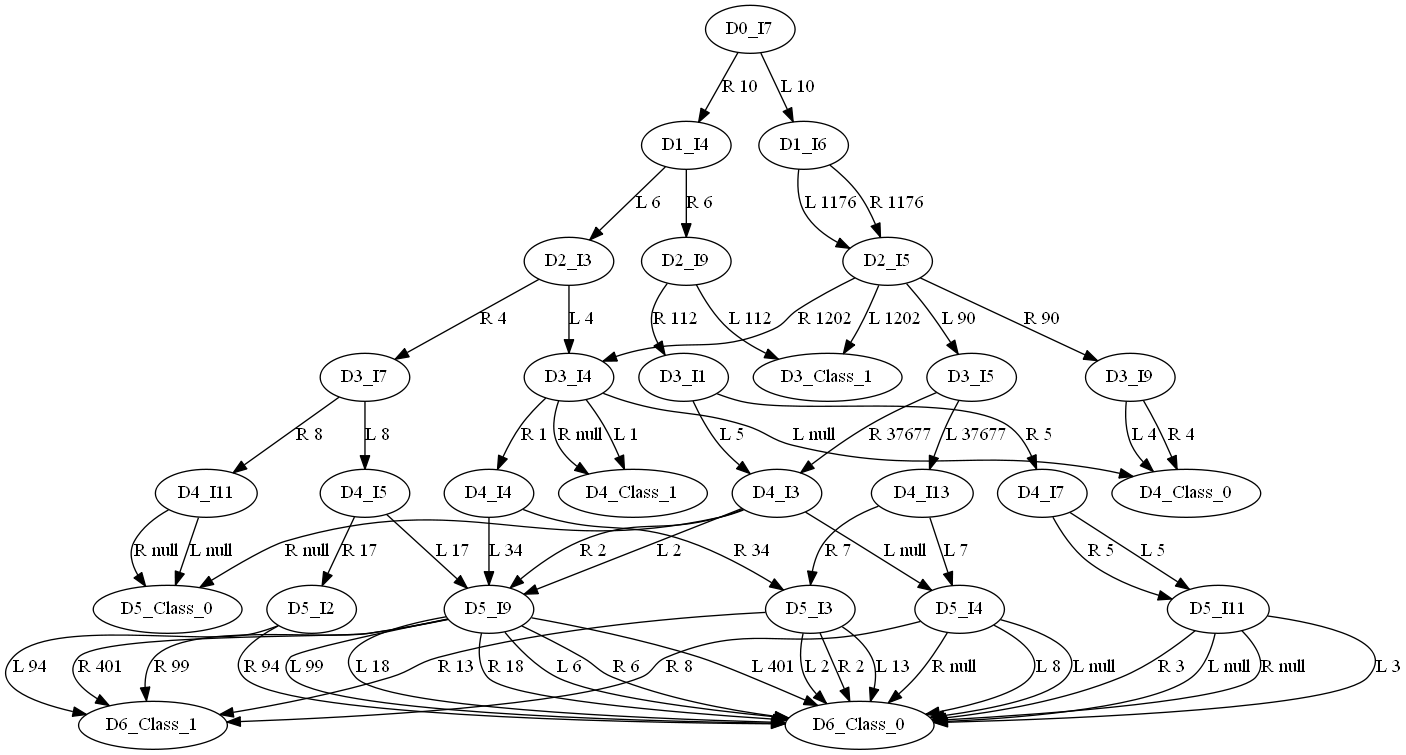

In [12]:
# display sample decision tree built
Image(filename="sample_output_decisiontree.png")

### 3.2.4 Comparing RF Accuracy with various Tuning Parameters

N-folds: 3  Max_depth: 5  Min size: 20 


Trees: 1
Scores: [67.5676, 70.2703, 70.2703]
Mean Accuracy: 69.369%
Training time: 0.6051356792449951  seconds

Trees: 5
Scores: [71.7718, 69.0691, 75.0751]
Mean Accuracy: 71.972%
Training time: 2.1814849376678467  seconds

Trees: 10
Scores: [68.4685, 74.7748, 72.0721]
Mean Accuracy: 71.772%
Training time: 4.999709129333496  seconds

Trees: 20
Scores: [69.97, 74.4745, 71.7718]
Mean Accuracy: 72.072%
Training time: 8.353610754013062  seconds

Trees: 30
Scores: [74.1742, 72.3724, 72.3724]
Mean Accuracy: 72.973%
Training time: 13.86149263381958  seconds

Trees: 40
Scores: [75.976, 73.2733, 70.2703]
Mean Accuracy: 73.173%
Training time: 18.861427783966064  seconds

Trees: 50
Scores: [70.5706, 75.3754, 71.1712]
Mean Accuracy: 72.372%
Training time: 22.8014235496521  seconds

Top 20 Features in decreasing order of importance:

Summed gini index for a feature across all trees - lower the gini index the better

 [('Medium_Freq_C9', 0.0), ('Missing10', 


Trees: 1
Scores: [65.1652, 64.2643, 68.1682]
Mean Accuracy: 65.866%
Training time: 0.5663533210754395  seconds

Trees: 5
Scores: [73.2733, 69.0691, 72.0721]
Mean Accuracy: 71.472%
Training time: 3.039102077484131  seconds

Trees: 10
Scores: [70.8709, 72.0721, 73.5736]
Mean Accuracy: 72.172%
Training time: 5.188641309738159  seconds

Trees: 20
Scores: [69.6697, 76.8769, 70.5706]
Mean Accuracy: 72.372%
Training time: 11.198851346969604  seconds

Trees: 30
Scores: [74.4745, 72.6727, 72.3724]
Mean Accuracy: 73.173%
Training time: 16.054837465286255  seconds

Trees: 40
Scores: [72.0721, 72.0721, 70.5706]
Mean Accuracy: 71.572%
Training time: 22.929447174072266  seconds

Trees: 50
Scores: [73.2733, 75.3754, 69.3694]
Mean Accuracy: 72.673%
Training time: 27.90587568283081  seconds

Top 20 Features in decreasing order of importance:

Summed gini index for a feature across all trees - lower the gini index the better

 [('Missing18', 0.0), ('Medium_Freq_C10', 0.0), ('Missing23', 0.0), ('Medium_

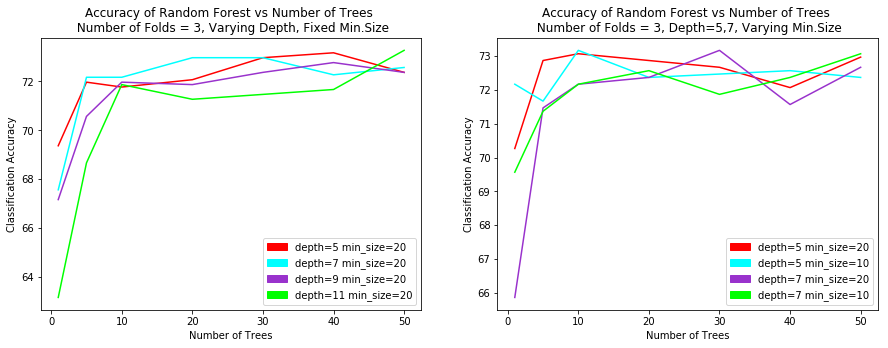

In [166]:
#Plotting graphs 
number_of_trees = [1, 5, 10, 20, 30, 40, 50]
plt.figure(figsize=(15,5),) 
plt.subplot(1,2,1)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Varying Depth, Fixed Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 7, min_size = 20), color='aqua')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 9, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 11, min_size = 20), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=7 min_size=20')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=9 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=11 min_size=20')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])
plt.subplot(1,2,2)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Depth=5,7, Varying Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 5, min_size = 10), color='aqua')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 7, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(dataset = toy_dataset, n_trees = number_of_trees, n_folds = 3, max_depth = 7, min_size = 10), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=5 min_size=10')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=7 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=7 min_size=10')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])

### 3.2.5 RF Performance and Accuracy on Toy Dataset

RF trains quickly for the toy test and train datasets. We got the same accuracy as the baseline ~ 75% on toy train and test. When trained with categorical features, more depth gave better accuracy. However, the difference was only marginal with various tuning parameters experimented with. We got similar accuracies using just numerical features as well as numerical with categorical features. 

### 3.2.6 Scaling Random Forest

Next, we will talk about the problem of how to scale DTs and RFs to work with very large datasets. 

### 1. Issues with using un-parallelized DTs on large data sets:

> 1. Typically trees built are small and of shallow depth ~ depth = 10 and can be kept in memory while **trees built with large datasets will be too large to keep in memory**. 

> 2. **Data set is too big to scan over on a single machine.**

### 2. Why are DTs and RFs suitable for scaling?

> Due to the following reasons, learning DTs are highly amenable to parallelization:

> 1. Once a split of a node is determined, the **two branches can be further expanded independent of each other** as they are disjoint regions and a data point will belong to only one of these branches at any point of time. 

> 2. **Loss functions/purity measures** used to determine the purity of nodes for splitting **can be modified to make them associative and commutative** if they are not. This allows them to be used in a scalable fashion and by using in-memory mappers, combiners training can be made faster. 

> 3. Random forest uses an ensemble of trees where **each tree is built indepdent of each other**, making it perfectly suitable for scaling as there is no dependency between thenm 

> 4. Also each mappers' records are like a random sample, in a way performing bootstrapping/bagging at scale. **For large data sets, local data replace bootstrap: making it embarassingly parallel**.

### 3. How to scale DTs?

> **Pre-Processing**: Assuming that pre-processing has been done on data to be fit by binning numeric features and bucketing or one-hot encoding categorical features. 

> **Goal: We want to know what is the best split for a node on the frontier?** 

> **How to divide and conquer?**

> * **DTs are built one level at a time in Map Reduce. That is, all frontier nodes are grown in parallel since data can only be assigned to one path. ex. left and right child of a node can both be expanded at the same time in the same level as they are independent of each other.**


> * **Modifying purity measure/Loss functions: Purity measures such as variance are not associative. Similarly, Gini Index is not. However, by collecting the counts of classes 0 and 1 in each split node and aggregating at the end to calculate Gini Index makes it associative. That is, dont calculate purity measures at mapper level but aggregate and calculate at the reduce level to train DT at scale. This makes the purity measure functions associative and commutative, allowing us to make the problem embarassingly parallel.**

> **Algorithm Details:**

> * Master node is responsible for all book-keeping and decision making in this process while building the DT one level at a time. Master decides which nodes and splits to consider. MapReduce computes quality of those splits. Master then grows the tree for a level. This process is repeated until all terminal nodes meet the stopping criteria. 


> * In Map Reduce, **Mapper considers a number of possible splits (X(i), v) on its subset of the data. For each split, mapper stores partial statistics and sends partial-split statistics to reducers. Reducer collects all partial statistics and determines best split. Master Grows the tree for one level.**


> * One efficient way to speeden the learning process is to use **in-memory build reducers**. When the amount of data that needs to be processed by a mapper at any stage is small enough to fit in M/Y, then a mapper is skipped and an in-memory reducer is called which builds the DT in memory. 


> * **In-memory mappers and combiners** can be used wherever applicable along with in-memory build reducers. **This will save a lot of training time and reduce the network transfer load**.  We can use as many reducers as we want, more the better specially if in-memory build reducers are used. 


> * **ex. PLANET: Parallel Learner for Assembling Numerous Ensemble Trees** is one such example implementation of this algorithm, where the model uses a sequence of MapReduce jobs to build a decision tree. 

### 4. Architecture of DT MR Framework:

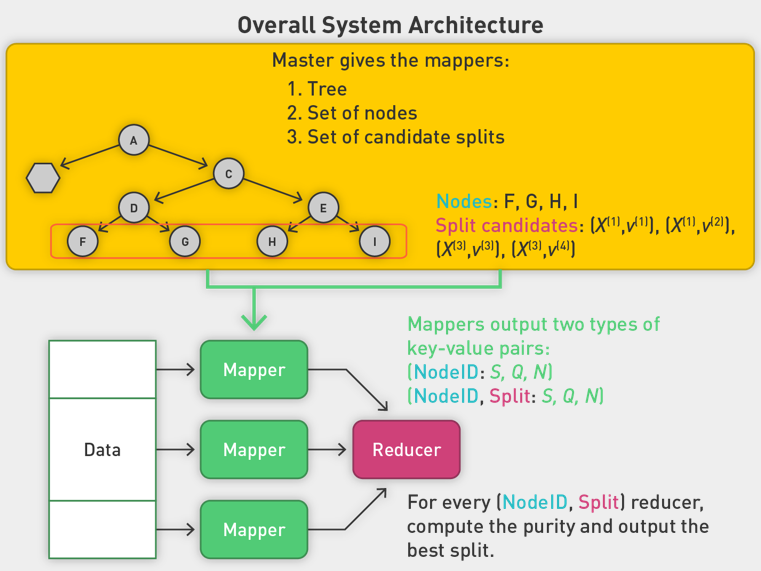

In [13]:
# display sample decision tree built
Image(filename="image_16_sample_tree.png")

### 5. Pseudo-Code for Distributed DT Learning:

**Stage 1:  Initializing**

    1. Upload data to MapReduce cluster.
    2. Collect feature information to driver to get candidate split values for all features. 
    3. Discretize features if necessary.
    4. Initialize tree at the driver T - with empty root node as placeholder and two child nodes in initial tree. 

**Stage 2: Pseudo-Code: While There Are Nodes to Grow**

**Master node**:

    1. Broadcast the current tree and variable discretization to workers. 
    2. Mark all new nodes, form the frontier of the tree.
    3. Ship variable and candidate split points to all mappers

**MapReduce**:

    1. Score each candidate split for each frontier node. 
    2. Collect sufficient statistics by mapping each data point (to a leaf node).

        Mapper Tasks:
        --------------
        1. Each mapper sees a subset of the data D.
        2. Mapper "drops" each data point to find the appropriate leaf node L.
        3. For each leaf node L, it keeps statistics about: 
            * The data reaching L.
            * The data in left and right subtree under split S.
        4. Keeps tallies for both parent and child nodes 
            * ex. if 2 parent nodes - > 4 child nodes. Therefore, needs to keep tab of all of the 6 nodes for each split. 
        5. Output from mappers is of the form (NodeID, Q,S,N) and for child nodes could be (NodeID, Split.NodeID, Q,S,N)
        6. Q, S, N are counts of values or output labels in each node aggregated in the reducer phase.

        Reducer Tasks:
        --------------
        1. Aggregates the statistics from mapper.
        2. Determines the best split for each tree node.
        3. Sends them back to Mapper
        4. Collected output from FindBestSplit reducers
           * ex. details about which node to split, which feature and value to split on and what is the resulting impurity. 
           * (Split.NodeID, Attribute, Value, Impurity)
    
**Back to Master node**:

    1. Selects the best split for each node on the frontier. 
    2. Update tree T. 
    3. Start from Stage 2 again as long as there are nodes to grow and there only terminal nodes left. 


** Three Types of MapReduce Jobs**:

    1. Initialization: Is run once first for each attribute, identifies values to be considered for splits
    2. FindBestSplit: Is run multiple times to Find the best split (when there are too many data to fit in memory)
    3. InMemoryBuild: Is similar to BuildSubTree (but for small data); Grows an entire subtree once the data fit in memory
    and is run once last. It is not passed thru mappers and passed through this reducer one time. 

    If data in mappers is small enough, later run MapReduce InMemoryBuild job on the node. Otherwise, run MapReduce FindBestSplit job for both nodes. 


### 6. Potential challenges while building a DT at scale:

> 1. **Amount of book-keeping to be done**: There are several details that need to be kept track of at each stage of the Map Reduce stages such as the tree structure, nodes considered for splitting, current nodes, variables quantile/binning values and various statistics for each split need to be maintained for both the parent and child nodes. 

> 2. **Difficulty in debugging:** Amount of book-keeping that needs to be done can make the code cumbersome and buggy, making debugging potentially very challenging. 

### 7. Decision to use homegrown RF on toy dataset but use Spark ML on full dataset

> Hence, we have decided to implement a homegrown version of the RF but use Spark ML APIs to run code on entire dataset as dataframes. In section 4, we show implementation details for data transformation based on EDA using dataframes and perform LR, RF on full data set using Spark ML. We decided to use dataframes and Spark ML on entire dataset as they are efficiently written to perform well and can be easily used to scale well on large datasets. 

## 4. Algorithm Implementation - Using Full Dataset

#### Parse the input RDDs

In [102]:
# helper function to parse the input rdd
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    f = features + [label]
    return(f)

In [103]:
# parse the train rdd
ctr_train_RDD_cached = trainRDD.map(parse)

# parse the heldout rdd
ctr_heldout_RDD_cached = heldOutRDD.map(parse)

In [109]:
# parse the test rdd
ctr_test_RDD_cached = fulltestRDD.map(parse)

#### Convert the RDDs to Spark Dataframes

In [105]:
# Convert the entire train RDD to Dataframe
start = time.time()

ctr_df_train = ctr_train_RDD_cached.toDF(FIELDS).cache()

print("Completed in ", time.time() - start , " seconds")

start = time.time()

ctr_df_heldout = ctr_heldout_RDD_cached.toDF(FIELDS).cache()

print("Completed in ", time.time() - start , " seconds")


Completed in  2.404324531555176  seconds
Completed in  0.4237198829650879  seconds


In [110]:
# Convert the entire train RDD to Dataframe
start = time.time()

ctr_df_test = ctr_test_RDD_cached.toDF(FIELDS[:-1]).cache()

print("Completed in ", time.time() - start , " seconds")


Completed in  0.5278060436248779  seconds


### Data Preprocessing

#### Convert blanks to None

In [111]:
# Convert all Blank values to Nulls

from pyspark.sql.functions import *

for f in FIELDS:
    ctr_df_train = ctr_df_train.withColumn(f,when(col(f) != "", col(f)).otherwise(None))
    ctr_df_heldout = ctr_df_heldout.withColumn(f,when(col(f) != "", col(f)).otherwise(None))
    

for f in FIELDS[:-1]:
    ctr_df_test = ctr_df_test.withColumn(f,when(col(f) != "", col(f)).otherwise(None))

#### Convert numerical columns to float

In [112]:
numericCols = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']

categoricalColumns = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

# Convert all numerical features to float
for col_name in numericCols:
    ctr_df_train = ctr_df_train.withColumn(col_name, col(col_name).cast('float'))
        
    ctr_df_heldout = ctr_df_heldout.withColumn(col_name, col(col_name).cast('float'))

    ctr_df_test = ctr_df_test.withColumn(col_name, col(col_name).cast('float'))

# Convert label to integer
ctr_df_train = ctr_df_train.withColumn("Label", col("Label").cast('int'))
ctr_df_heldout = ctr_df_heldout.withColumn("Label", col("Label").cast('int'))

# Cache the train and heldout datasets
ctr_df_train = ctr_df_train.cache()
ctr_df_heldout = ctr_df_heldout.cache()

### PART A: DATA TRANSFORMATION USING DATAFRAMES

### 4.1 Data Transformation Pipeline 

Notes: How EDA data tranformations decisions were used for building pipeline?

## Building the Data Pipeline


Based on the EDA from before ,the following data tranformations will be performed as part of the data pipeline for the full dataset.

1. Impute any missing data for the numerical columns with a median. 
2. Standardize the numerical columns. This includes I1 through I13. 
3. Reclassify high frequency categories as high for all the categorical features. Anything, that occurs atleast 10% of the time is considered as high
4. Reclassify medium frequency categories as medium for all the categorical features. Anything, that occurs 2 to 10% of the time is considered as medium.
5. Reclassify the rest of the categories as rare for all the categorical features.
6. Reclassify any missing categorical value as "missing".
7. Onehot encode all the categorical features.


#### Custom Reclass Transformer

The reclass transformer reclassifies the categories of a given feature to "high", "medium", "missing" or rare. High frequency categories are classified as "high". Medium frequency categories are classified as "medium". The rest of the categories are bucketed in to a category called "rare". If there afre no values present, then it is reclassified as missing.

In [ ]:
from pyspark.ml.param.shared import *

# HasHighFrequency is a class to enable setting the threshold for high frequency categories.


class HasHighFrequency(Params):

    high_frequency = Param(Params._dummy(),
            "high_frequency", "high_frequency",
            typeConverter=TypeConverters.toFloat)

    def __init__(self):
        super(HasHighFrequency, self).__init__()
    
    #Setter for high frequency categories
    def setHighFrequency(self, value):
        return self._set(high_frequency=value)
   
    #Getter for high frequency categories
    def getHighFrequency(self):
        return self.getOrDefault(self.high_frequency)
    

# HasMediumFrequency is a class to enable setting the threshold for medium frequency categories.


class HasMediumFrequency(Params):

    medium_frequency = Param(Params._dummy(),
            "medium_frequency", "medium_frequency",
            typeConverter=TypeConverters.toFloat)

    def __init__(self):
        super(HasMediumFrequency, self).__init__()
   
    #Setter for medium frequency categories

    def setMediumFrequency(self, value):
        return self._set(medium_frequency=value)
    
    #Getter for medium frequency categories
    def getMediumFrequency(self):
        return self.getOrDefault(self.medium_frequency)

In [ ]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.sql.functions import udf

# ReclassTransformer provides the methods to set thresholds for high and medium frequencies. 
# It also provides a method to transform input column by reclassifying the categories to high, medium, rare and missing.
 
class ReclassTransformer(Transformer, HasInputCol, HasOutputCol,HasHighFrequency,HasMediumFrequency):
 
   @keyword_only
   def __init__(self, inputCol=None, outputCol=None):
    
       super(ReclassTransformer, self).__init__()
       kwargs = self._input_kwargs
       self.setParams(**kwargs)
 
   @keyword_only
   def setParams(self, inputCol=None, outputCol=None):
       kwargs = self._input_kwargs
       return self._set(**kwargs)

  
   # Tranform method to reclassify categories
   def _transform(self, dataset):
     
    def topcategories(category,high_frequency,medium_frequency):
        
        if not category:
            return "missing"
    
        if category in high_frequency:
            return "high"
        elif category in medium_frequency:
            return "medium"
        else:
            return "rare"
    
    # Get the high frequency categories based on a given threshold
    high_frequency = dataset.stat.freqItems([self.getInputCol()], self.getHighFrequency()).collect()[0].__getitem__(self.getInputCol()+"_freqItems")
    
    # Get the medium frequency categories based on a given threshold
    medium_frequency = list(set(dataset.stat.freqItems([self.getInputCol()], self.getMediumFrequency()).collect()[0].__getitem__(self.getInputCol()+"_freqItems")) - set(high_frequency))

    #Create a dictionary to store index for categories - "high","medium","missing","rare"
    self.index_to_string_map = dict(enumerate(["high","medium","missing","rare"]))
    
    # Create a reverse lookup to get the index for a given category
    self.string_to_index_map = {v: float(k) for k, v in self.index_to_string_map.items()}
    
    # This method passes the high and medium frequency categories to the top categories method
    def t_udf(high_frequency,medium_frequency):
        return udf(lambda category : topcategories(category,high_frequency,medium_frequency))
    
    # Pass a categorical column to a udf function
    ds = t_udf(high_frequency,medium_frequency)(dataset[self.getInputCol()])
    
    # Convert the reclassified category to its corresponding index
    def stringtoIndex_udf(index_map):
        return udf(lambda l: index_map[l])
    
    # Reclassify the input column
    dataset = dataset.withColumn(self.getOutputCol(), ds)
    
    # Pass the category to index dictionary to the function that returns the indices given a column
    stringtoIndex = stringtoIndex_udf(self.string_to_index_map)(dataset[self.getOutputCol()])
    
    # Get the indices for the reclassified columns.
    dataset = dataset.withColumn(self.getOutputCol()+"Indexer",stringtoIndex.cast('double'))
    
    return dataset

#### Data Pipeline construction


In [213]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler,Imputer

stages = []

#  Reclassify the categorical columns and one hot encode them.
for categoricalCol in categoricalColumns:
    reclass = ReclassTransformer(inputCol=categoricalCol, outputCol=categoricalCol + "Reclassed").setHighFrequency(0.1).setMediumFrequency(0.02)
    encoder = OneHotEncoder(inputCol=reclass.getOutputCol() + "Indexer", outputCol=categoricalCol + "classVec")
    stages += [reclass, encoder]

In [214]:
# Impute the numerical features with the respective median values

for n in numericCols:
    
    imputer = Imputer(inputCols=[n], outputCols= [n + "Imputed"]).setStrategy("median")
    stages += [imputer]

In [216]:
# Assemble all the numerical features in to a vector.
numassemblerInputs = [n + "Imputed" for n in numericCols]

numAssembler = VectorAssembler(inputCols=numassemblerInputs, outputCol="numfeatures")

stages += [numAssembler]

# Standardize all of the numerical features
scaler = StandardScaler(inputCol="numfeatures", outputCol="scalednumfeatures",withStd=True, withMean=True)

stages += [scaler]

# Assemble the standardized numerical features and the one-hot encoded categorical features in to one feature vector.
assemblerInputs = ["scalednumfeatures"] + [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

#### Fit the data pipeline

In [218]:
from pyspark.ml import Pipeline

# Initialize the data pipline
pipeline = Pipeline(stages = stages)

start = time.time()

# Fit the pipeline with the train data
pipelineModel = pipeline.fit(ctr_df_train)

print("Completed in ", time.time() - start , " seconds")

start = time.time()

# Transform the train data
traindf = pipelineModel.transform(ctr_df_train)

print("Completed in ", time.time() - start , " seconds")


Completed in  270.42449378967285  seconds
Completed in  241.79017853736877  seconds


In [219]:
# Select the features and label columns from the transformed train dataset.
selectedCols = ['Label', 'features']
traindf = traindf.select(selectedCols).cache()

In [220]:
# Rename the Label column to label. This is required for cross validation that actually looks for the label with a lower case.
traindf = traindf.withColumnRenamed("Label","label")


root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



### PART B: LR AND RF WITH SPARK ML

### 4.2 LR in Spark ML

#### Run cross validations for Logistic Regression

In [221]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression

# Initialize model evaluator for a binary classification.
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

#Initialize logistic regression 
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', threshold = 0.262768, maxIter=20)

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01])
             .addGrid(lr.elasticNetParam, [0.8,1.0])
             .build())

# Create 5-fold CrossValidator
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel_lr = cv_lr.fit(traindf)

#### Get the best logistic regression model parameters

In [222]:
# Print the parameters of the best Logistic regression model.
bestmodel = cvModel_lr.bestModel
print(bestmodel._java_obj.getRegParam())
print(bestmodel._java_obj.getElasticNetParam())
print(lr.getThreshold())

#### Get the training loss per iteration for the best model


Text(0.5, 1.0, 'Loss per iteration')

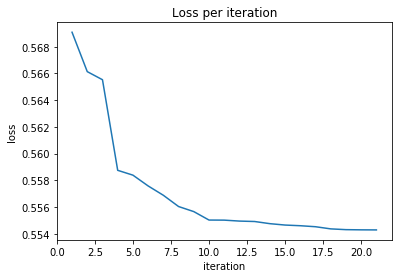

In [224]:

# Get the model summary
best_model_training_summary = cvModel_lr.bestModel.summary

# Get the objective history (loss)
objectiveHistory = best_model_training_summary.objectiveHistory

# Create a dataframe to store the loss and iterations.
train_loss_per_iteration = pd.DataFrame(
    {
     'iteration': list(range(1,len(objectiveHistory)+1)),

     'loss': objectiveHistory
    })

# Plot training loss per iteration
ax = sns.lineplot(x="iteration", y="loss", data=train_loss_per_iteration)
ax.set_title('Training Loss per iteration')


#### Calculate Training accuracy, False positive rate, True positive rate, True Negative rate and False Negative rate

In [225]:
train_accuracy = best_model_training_summary.predictions.select("label","rawPrediction","probability","prediction").where(col("label")==col("prediction")).count()/best_model_training_summary.predictions.count()

print("The accuracy on the test set is :", train_accuracy)

The accuracy on the test set is : 0.6591952537620578


In [226]:
TPR = best_model_training_summary.predictions.select("label","rawPrediction","probability","prediction").where(col("label")==col("prediction")).where(col("Label")==1.0).count()/best_model_training_summary.predictions.where(col("Label")==1.0).count()
print("The True positive rate on the test set is :", TPR)

FPR = best_model_training_summary.predictions.select("label","rawPrediction","probability","prediction").where(col("label")!=col("prediction")).where(col("Label")==0.0).count()/best_model_training_summary.predictions.where(col("Label")==0.0).count()
print("The False positive rate on the test set is :", FPR)

TNR = best_model_training_summary.predictions.select("label","rawPrediction","probability","prediction").where(col("label")==col("prediction")).where(col("Label")==0.0).count()/best_model_training_summary.predictions.where(col("Label")==0.0).count()
print("The True Negative rate on the test set is :", TNR)

FNR = best_model_training_summary.predictions.select("label","rawPrediction","probability","prediction").where(col("label")!=col("prediction")).where(col("Label")==1.0).count()/best_model_training_summary.predictions.where(col("Label")==1.0).count()
print("The False Negative rate on the test set is :", FNR)

The True positive rate on the test set is : 0.592473695761244
The False positive rate on the test set is : 0.31781845211478843
The True Negative rate on the test set is : 0.6821815478852116
The False Negative rate on the test set is : 0.407526304238756


#### Receiver-Characteristic Curve

* Please note that there is an issue with converting the dataframe output from model summary to pandas. The workaround is to save the dataframe as a csv file and then import the data back to a new spark dataframe, which can then be converted to pandas.*

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

18/12/15 03:50:06 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Deleted hdfs://clickratepredcluster-m/roc.csv


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'ROC Curve')

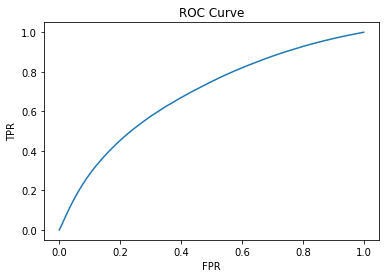

In [227]:

from pyspark.sql import SQLContext

# Get the roc for best model
roc = best_model_training_summary.roc

# Store the roc in a csv file.
sqlContext = SQLContext(sc)
!hadoop dfs -rm -r hdfs://clickratepredcluster-m/roc.csv
roc.write.csv("/roc.csv")

# Read the roc from the file and convert it to pandas
roc1 = sqlContext.read.format('com.databricks.spark.csv').options(header='false', inferschema='true').load('/roc.csv').toPandas()

roc1.columns = ["FPR","TPR"]

# Plot the roc curve
ax = sns.lineplot(x="FPR", y="TPR", data=roc1)
ax.set_title('ROC Curve')

*Based on the above ROC curve, a threshold between 0.2 and 0.3 seems to maximize true positive rate and minimize false positive rate*

#### Precision recall Curve

* Please note that there is an issue with converting the dataframe output from model summary to pandas. The workaround is to save the dataframe as a csv file and then import the data back to a new spark dataframe, which can then be converted to pandas.*

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

18/12/15 03:51:02 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Deleted hdfs://clickratepredcluster-m/pr.csv


Text(0.5, 1.0, 'Precision Recall Curve')

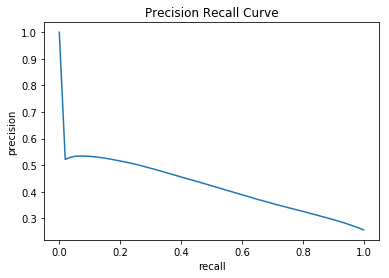

In [228]:
# Get the precision for the best model for training data
pr = best_model_training_summary.pr

!hadoop dfs -rm -r hdfs://clickratepredcluster-m/pr.csv

# Save the precision / recall dataframe as a csv   
pr.write.csv("/pr.csv")


# Read the csv in to a spark dataframe and then convert it to a pandas dataframe
pr1 = sqlContext.read.format('com.databricks.spark.csv').options(header='false', inferschema='true').load('/pr.csv').toPandas()

pr1.columns = ["recall","precision"]

# Plot the precision recall curve
ax = sns.lineplot(x="recall", y="precision", data=pr1)
ax.set_title('Precision Recall Curve')

*Based on the above precision recall curve, a threshold between 0.2 and 0.3 seems to provide the right balance between precision and recall*

#### F-measure By Threshold

* Please note that there is an issue with converting the dataframe output from model summary to pandas. The workaround is to save the dataframe as a csv file and then import the data back to a new spark dataframe, which can then be converted to pandas.*

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

18/12/15 03:53:32 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
Deleted hdfs://clickratepredcluster-m/fMeasure.csv


Text(0.5, 1.0, 'F1 Score by Threshold')

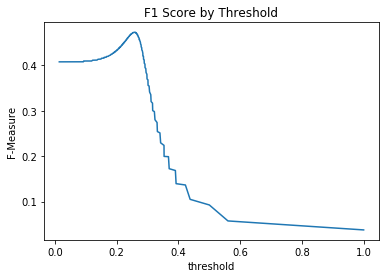

In [229]:
# Get the f1 score from the best model
fMeasure = best_model_training_summary.fMeasureByThreshold
!hadoop dfs -rm -r hdfs://clickratepredcluster-m/fMeasure.csv

# Write the F1 score in to a csv file
fMeasure.write.csv("/fMeasure.csv")

# Read the f1 file in to a spark dataframe and then convert it to pandas dataframe
fMeasure1 = sqlContext.read.format('com.databricks.spark.csv').options(header='false', inferschema='true').load('/fMeasure.csv')

fMeasure2 = fMeasure1.toPandas()

fMeasure2.columns = ["threshold","F-Measure"]

# Plot the F1-score by various thresholds
ax = sns.lineplot(x="threshold", y="F-Measure", data=fMeasure2)
ax.set_title('F1 Score by Threshold')

*Again, F1 score plot by threasholds confirms that threshold of 0.25 to 0.26 actually maximizes the F1-score*

In [230]:
# Get the threshold corresponding to maximum F1-score and use it for logistic regression model
fMeasure2.loc[fMeasure2['F-Measure'].idxmax()]

threshold    0.259851
F-Measure    0.473144
Name: 19, dtype: float64

#### Get the features along with coeeficients for Logistic Regression

In [231]:

# Get the attributes along with the coefficients from the best model
from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*traindf
        .schema[cvModel_lr.bestModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

#  Create a dataframe to store the coefficients
pd.DataFrame(
    {'Feature': attrs,
     'Coeeficients': cvModel_lr.bestModel.coefficients
    })


,Feature,Coeeficients
0,"(0, scalednumfeatures_0)",0.061525
1,"(1, scalednumfeatures_1)",0.020382
2,"(2, scalednumfeatures_2)",0.000000
3,"(3, scalednumfeatures_3)",0.000000
4,"(4, scalednumfeatures_4)",-0.160868
5,"(5, scalednumfeatures_5)",-0.120887
6,"(6, scalednumfeatures_6)",0.000000
7,"(7, scalednumfeatures_7)",-0.003951
8,"(8, scalednumfeatures_8)",0.000000
9,"(9, scalednumfeatures_9)",0.049391


*By examining the coefficients, we see that the coefficients has reduced to zero due to lasso regularization.*

#### Model Evaluation

In [232]:
# Tranform the heldout data using the data pipeline.
heldoutdf = pipelineModel.transform(ctr_df_heldout)

heldoutdf = heldoutdf.withColumnRenamed("Label","label")

# Select the features and label columns from the heldout dataset
selectedCols = ['features','label']

heldoutdf = heldoutdf.select(selectedCols).cache()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



#### Evaluate the model on the heldout dataset.

In [233]:
predictions = cvModel_lr.transform(heldoutdf)
#evaluator.evaluate(predictions)

0.6790132467542465

#### Accuracy on the heldout dataset

In [234]:
heldout_accuracy = predictions.select("label","rawPrediction","probability","prediction").where(col("label")==col("prediction")).count()/predictions.count()

print("The accuracy on the test set is :", heldout_accuracy)

The accuracy on the test set is : 0.6538995655096611


### 4.3 RF in Spark ML

### Random Forest Classifier

#### Run cross validations with a random forest classifier

In [235]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Initiliaze a binary classification evaluator
evaluator = BinaryClassificationEvaluator()


# Create ParamGrid for Cross Validation

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())


# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel_rf = cv.fit(traindf)



In [248]:
# for i,j in zip(cvModel_rf.avgMetrics, paramGrid):
#     print(i,j,"\n")

# Get the best model from the cross validation and check the trees
best_model_training_rf = cvModel_rf.bestModel
best_model_training_rf.trees

[DecisionTreeClassificationModel (uid=dtc_6c4e0c2b37be) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_dc5bee1ca6f5) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_86908a496741) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_d3d510eede30) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_1472c07bc847) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_c2de0c569d1a) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_c6f13b29f573) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_c4b84e69cdbb) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_3b4b4ce9c777) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_92843ee8f0dc) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_92d1c7a3198f) of depth 6 with 127 nodes,
 DecisionTreeClassificationModel (uid=dtc_7da1c26dcf7e) of depth 6 with 127 nodes,
 Dec

*The best model has a depth of 6. The number of nodes is 2^7 -1 = 127.*

####  Run predictions on the heldout dataset 

In [241]:
prediction_rf = cvModel_rf.transform(heldoutdf)

In [243]:
# Accuracy for the held out dataset

heldout_accuracy_rf = prediction_rf.select("label","rawPrediction","probability","prediction").where(col("label")==col("prediction")).count()/prediction_rf.count()

print("The accuracy on the held out set is :", heldout_accuracy_rf)

The accuracy on the held out set is : 0.7550209940795322


### 4.4 Comparison of Random Forest vs Logistic Regression Results

#### Accuracy 

Our Random forest model is more accurate than the logistic regression one by about 10 percentage points. There are a number of reasons for this :

* Random forest reduces variance by not overfitting the training data. 

* Random forest also builds multiple trees by using only a subset of the features and therefore is able to learn the feature space better, especially given that we have a large number of numerical and categorical features.

#### Performance:

* Data transfromation with dataframes and ML models using Spark ML models ran lightening fast on Google Cloud Setup for data set of size 10GB (results took tens of seconds to minutes for EDA and training ML models). We have also updated our GCP cloud cluster to use 5 worker nodes and the following configuration change was done to allocate more processory memory and power to the cluster. 

        conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'), 
        ('spark.executor.cores', '4'), ('spark.cores.max', '24'), ('spark.driver.memory','10g')])

* For random forest models, as the depth of the tree and the number of trees to be fit was changed to 10 depth and about 30 trees, each iteration of RF started taking longer time. 

## 5. Application of Course Concepts

### 5.1 Course Concepts:

**Bias Variance Tradeoff**

Given the large number of features in this dataset, we needed to be careful not to overfit our data. A very complex model does not generalize well (high variance) while an overly simple model gives too much credit to the data itself (e.g., high bias: we believe too much in our data to do the work for us). These factors are introduced in model selection. We therefore explored two models (Logistic Regression and Decision Trees) that each allow us to identify important features and also adjust for complexities to avoid overfitting. In Logistic Regression, we used Lasso Regularization to avoid overfitting and identify unimportant features (eg. features where the weights are driven to zero). Decision Trees can also be made simpler or more complex by adjusting the depth of the trees, and has specific tools to identify important features. Together these tools helped us to optimize our models.

**Normalization:**

Given that the features in the dataset are on widely different scales, we needed to standardize the data to avoid lending over importance to features with bigger values. This was more important for the logistic regression model as decision trees opened on splits of each variable rather than a weighting of variables relative to one another.

**Map Reduce Design/Broadcasting/Lazy Evaluation**

The map reduce design lends itself very well to this problem. Given that we can compute each record as a pair RDD (label and values), and that the operations are associative and commutative, each row can be computed independently. We can cache our RDDs and use Spark’s functional programming design and lazy evaluation to avoid multiple passes over the data at each step. In linear regression, broadcasting values such as medians (which cannot be obtained in the RDD) helps us to optimize the process as well.

**One Hot Encoding**

Another one of the concepts learned in this course that we applied in this project is One-hot encoding to convert the categorical variables to numerical before feeding them into a classifier. Instead of applying the conventional one-hot encoding method that converts all unique categories to a separate column filled with 1's and 0's, we applied an alternative approach to shrink the size of our data set. Our approach included bucketing the one-hot encoded unique values for each variable into 4 buckets based on frequency counts: high, medium, low frequency & missing. 

**Scalability**

The most important course concept that we have applied throughout this project is Scalability. Starting from feature engineering and data transformations all the way to model implementation, we have used Spark RDDs and Dataframes in order to parallize our processes and leverage the Map and Reduce framework with different worker nodes that was taught to us in this course. This enabled us to run our models on a very large dataset very efficiently. Some example processes where we used an MR scalable framework and Spark techniques like "broadcasting" and "caching" are the implementation of One-hot encoding, gradient descent for LR, and RF model.

**Implications of iterative algorithms - arvindh spark vs hadoop**

Many of the machine learning algorithms are iterative in nature. For example, a machine learning problem mostly is an optmization problem such as reducing an error iteratively. As such we will need to store intermediate results and iterate on the algorithm such as gradient descent to reduce the error. Map Reduce tasks cannot cache intermediate results and one has to store the data in disks and kick off a seperate map reduce job to continue the next iteration. The overhead of flushing data to disk causes the tasks ot be super slow. Apache spark is an im-memory computation engine that persists intermediate states in memory and thus is suitable for realtime stream processing and iterative algorithms.


### 5.2 Conclusion:


**Model Performance**
The logistic regression model produced an accuracy of 65% on both the train and the heldout datasets. The random forest model produced an accuracy of 75% on the heldout dataset. 

**Running time**
Both Randomforest and logistic regression model was fit using 5-fold cross validation and took close to an hour each. However, when Random forest was run with a max depth of 30, the algorithm was taking more than 6 hours to train.

**Tuning and Evaluation**

* For both logistic regression, we used the BinaryClassificationEvaluator to evaluate our models. We used wareaUnderROC (ROC curve) as the evaluator for the Logistic regression and gini index as the evaluator for the random forest model.


* We also noticed that with the default threshold of 0.5, the accuracy on the train data for Logistic regression was 75% but then at the expense of a really high False negative rate of about 90%. That is, our model was almost always predicting zero and since the number of ones (as true label) was very less, we did not lose the accuracy but sure did poorly on predicting the ones. This means that we are potentially losing revenue opportunities. By carefully examining the ROC curve and F1- measure fore various thresholds, we chose a threshold of 0.26 that maximizes the F1-score. 


* In our logistic regression model, since we are dealing with a large feature space, we employed Lasso regularization to avoid overfitting. For the random forest model, our best model has twenty tress with each tree having a maximum depth of 6.


**In the end, Random forest is robust to variance in data and high dimensional space and this outperformed our logistic regression model.** 
    
### 5.3 Future Ideas for Implementation:

**1. Correlation between features**
In a logistic regression context, features should not be highly correlated with each other. We saw that in our case a lot of features were highly correlated. However, we didn't make any feature exclusions based on multicollinearity, since we focused more on our tree-based algorithm that is not affect by feature correlation. As a future improvement step, we would remove those highly correlated features before feeding into the LR model. 

**2. Imbalance of labels**
Our classification labels were imbalanced (75% label=0, 25% label=1). This could potentially decrease our model performance. A future step that our team would take to improve performance would be to balance the classes using bootstrap random sampling. 

**3. Outliers & Skewness**
One noticeable issue that could be addressed to enhance performance would be to treat some extreme outliers. When looking at our numeric feature distributions we noticed some high positive skews. One way to deal with this would be to put a 'ceiling' on the values of features that would not exceed 3 standard deviations of each variable. Additionally, we would like to try taking the log of the highly skewed numeric features to smooth out the skewed distributions. 

**4. Columns/rows with large % of missing values**
Finally, we noticed that a few variables had a high % of missing values. Due to the fact that we dealt with missing values in our categorical feature transformations, we decided to not make any column exclusions. However, it would be a good idea to exclude those columns and even rows with a certain threshold percentage of missing values and evaluate model performance. It is likely that our performance could be improved by doing so. 